In this notebook, we re-perform hierarchical clustering on syllable features so that we can order the syllables by feature similarity.
Permuted orderings aid in visualization and interpreation of the syllables.

We will refer to the 90 syllables in the main paper's analyses, which correspond to the 90 most frequently used syllables (as described in the paper), as the "analyzed syllable set", $\mathcal{V}^\star$.

The original paper presented a permuted order of syllables based on hierarchical clustering.
However, this ordering was not explicitly provided in the dataset (the raw data orders syllables from most to least frequently used).
Moreover, the syllables included in the clustering analysis are not the exacrt same set of syllables used in the other paper results.

In [2]:
%load_ext autoreload
%autoreload 2

%load_ext dotenv
%dotenv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import itertools
from pathlib import Path
import pickle
from tqdm.auto import tqdm

from math import prod
import numpy as onp
import pandas as pd
from scipy.signal import find_peaks
from sklearn.covariance import MinCovDet
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN

from spin import NeighborhoodSPIN                           # Install from https://github.com/otaviocv/spin
from spin.neighborhood_spin import initial_weight_matrix    

import colorcet as cc 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from blume.table import Table                               # Install from http://github.com/swfiua/blume.
                                                            # Must be imported AFTER matplotlib, otherwise get cryptic docstring error
from dtd.viz import set_cluster_edge_ticks

In [4]:
DATA_DIR = Path(os.environ['DATA_DIR'])

n_sessions_all = 501    # Number of sessions in original data
session_length = 36000  # Based on 20 minutes @ 30 fps

# Sessions to exclude, e.g. due to outlier or possible glitch
EXCLUDED_SESSIONS = [217,]

**Load dimensionally-reduced image data and scalar variables**

In [5]:
datadict = dict(
    data=onp.empty((n_sessions_all, session_length, 10)),        # Will be renamed 'pcs'
    dist_to_center=onp.empty((n_sessions_all, session_length)),
    height=onp.empty((n_sessions_all, session_length)),
    velocity=onp.empty((n_sessions_all, session_length)),
    # syllable_ids=onp.empty((n_sessions_all, session_length)),  # Manually added later
)

# =========================================================================================

filepath = DATA_DIR/"original/dataset.pkl"

with open(filepath, 'rb') as f:
    all_data = pickle.load(f, encoding='latin1')
    print (f"Loaded `all_data` from:\n\t{filepath}\n")

bad_frames_by_session = []
for i_session, (session_name, session_data) in enumerate(all_data.items()):
    # Get indices of bad frames
    bad_idxs = onp.setdiff1d(onp.arange(session_length), session_data['good_idx'])
    
    for key in datadict.keys():
        this_data = onp.asarray(session_data[key].squeeze())
        this_data[bad_idxs] = onp.nan
        datadict[key][i_session] = this_data

    # Save bad indices to filter out syllable ids as well
    bad_frames_by_session.append(bad_idxs)

# Remove excluded sessions
datadict = {k: onp.delete(v, EXCLUDED_SESSIONS, axis=0) for k, v in datadict.items()}

# Rename 'data' to 'pcs'
datadict['pcs'] = datadict.pop('data')

Loaded `all_data` from:
	/home/groups/swl1/eyz/data/moseq-drugs/original/dataset.pkl



**Load syllable labels**

In [6]:
filepath = DATA_DIR/"original/syllablelabels.pkl"
with open(filepath, 'rb') as f:
    syllable_ids = pickle.load(f, encoding='latin1')
    
    print (f"Loaded `syllable_ids` from:\n\t{filepath}")

# Reorganize into matrix, shape (n_sessions, session_length)
syllable_ids = syllable_ids.reshape(n_sessions_all, session_length)

# NaN out bad indices
for i_session, bad_idxs in enumerate(bad_frames_by_session):
    syllable_ids[i_session][bad_idxs] = onp.nan

# Remove excluded sessions
syllable_ids = onp.delete(syllable_ids, EXCLUDED_SESSIONS, axis=0)

# Add to datadict
datadict['syllable_ids'] = syllable_ids
del syllable_ids

Loaded `syllable_ids` from:
	/home/groups/swl1/eyz/data/moseq-drugs/original/syllablelabels.pkl


In [7]:
for k, v in datadict.items():
    print(
        f"{k:<15} shape={v.shape}\tdtype={v.dtype}  "
        + f"min={onp.nanmin(v):.2f}, max={onp.nanmax(v):.2f}\t"
        + f"# nans={onp.sum(onp.isnan(v[...,0] if v.ndim==3 else v))}" 
    )

dist_to_center  shape=(500, 36000)	dtype=float64  min=0.00, max=1.05	# nans=21614
height          shape=(500, 36000)	dtype=float64  min=3.52, max=167.74	# nans=19530
velocity        shape=(500, 36000)	dtype=float64  min=-354.76, max=366.44	# nans=22016
pcs             shape=(500, 36000, 10)	dtype=float64  min=-421.34, max=1369.92	# nans=19530
syllable_ids    shape=(500, 36000)	dtype=float64  min=0.00, max=158.00	# nans=21030


The number of NaNs in the syllable data is greater than the number of NaNs in the image data because the syllable data has 3 NaN frames at the beginning of each session (due to the 
value of AR lag parameter).
Indeed, we find that $21030 - 19530 = 1500 = 3 \textrm{ frames } \times 500 \textrm{ sessions}$

**Load original syllable descriptions**

In [8]:
# Load plain text descriptions of syllables provided by Wiltschko et al, Supp Fig 3
filepath = DATA_DIR/"syllable_id_label_cluster_original.csv"

# We will eventually discard Wiltschko et al.'s category
aux_syllable_info = pd.read_csv(filepath)

# Drop "category" column produced by Wiltschko et al.
# aux_syllable_info = aux_syllable_info.drop(columns='category')

# Add rows for syllables with missing descriptions (from amongst the first 90)
tmp_rows = [
    [v, "", ""] for v in onp.setdiff1d(onp.arange(90), aux_syllable_info.id)  # "missing" syllables
]
aux_syllable_info = pd.concat(
    [aux_syllable_info, pd.DataFrame(tmp_rows, columns=aux_syllable_info.columns)]
)

# Sort and only keep info for first 90 syllables that we're interested in
aux_syllable_info.sort_values('id', inplace=True, ignore_index=True)
aux_syllable_info = aux_syllable_info[:90]

# ------------------------------------------------------------------------------------------------------------
# Empirical mean and cov of scalar variables (this what Wiltschok et al. 2020 report)
# NOTE: When possible, recompute these values using the exact points found via MCD on the PCs (MCD().support_).

syllable_ids = datadict['syllable_ids']
tmp_dict = {key: [] for key in ["height", "velocity", "dist_to_center"]}
for v in tqdm(range(90)):
    # Filter data for all those associated with syllable v 
    ii_session, ii_frame = onp.nonzero(syllable_ids == v)
    for key in tmp_dict.keys():
        this_data = datadict[key][ii_session, ii_frame]
        tmp_dict[key].append(
            f"{onp.nanmean(this_data, axis=0):.1f}" + f" \u00B1 " + f"{onp.nanstd(this_data):.1f}"
        )

aux_syllable_info = aux_syllable_info.assign(**tmp_dict)

aux_syllable_info

  0%|          | 0/90 [00:00<?, ?it/s]

id               description                 category       height  \
0    0                  Sedation          Sedation/freeze   17.0 ± 2.9   
1    1                  Sedation          Sedation/freeze   17.7 ± 2.6   
2    2                  Sedation          Sedation/freeze   19.3 ± 2.9   
3    3                  Sedation          Sedation/freeze   19.6 ± 2.9   
4    4  Belly down short shuffle  Fast forward locomotion   23.0 ± 2.7   
..  ..                       ...                      ...          ...   
85  85                                                      28.6 ± 6.6   
86  86    Supported two leg rear        Two-leg high rear  62.3 ± 11.2   
87  87  Unsupported two leg rear        Two-leg high rear  61.3 ± 12.2   
88  88      Head rear from hunch         Pause/scrunching   38.5 ± 9.8   
89  89            Fall from rear           Fall from rear  48.3 ± 13.0   

      velocity dist_to_center  
0    0.0 ± 0.1      0.8 ± 0.2  
1   -0.0 ± 0.1      0.7 ± 0.2  
2    0.0 ± 0.1      0.8 ± 0.2  
3    0.0 ± 0.1      0.8 ± 0.2  
4    3.3 ± 2.1      0.7 ± 0.2  
..         ...            ...  
85   0.1 ± 0.5      0.7 ± 0.2  
86   0.0 ± 0.4      0.9 ± 0.0  
87   0.2 ± 1.0      0.7 ± 0.2  
88   0.1 ± 0.6      0.7 ± 0.2  
89  -0.4 ± 2.2      0.8 ± 0.1  

[90 rows x 6 columns]

## Helper functions

### Confidence ellipse

In [9]:
def confidence_ellipse(mean, cov, ax, n_std=2.0, facecolor='none', **kwargs):
    """Draw covariance confidence ellipse.

    Adapted from
        https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html

    Parameters
    ----------
    mean (array-like): shape (2,)
    cov (array-like): shape (2,2)
    ax (matplotlib.axes.Axes): The Axes object to draw the ellipse into.
    n_std (float): The number of standard deviations to determine the ellipse's radiuses.
    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    
    pearson = cov[0, 1] / onp.sqrt(cov[0, 0] * cov[1, 1])
    
    # Use a special case to obtain the eigenvalues of this 2D dataset.
    ell_radius_x = onp.sqrt(1 + pearson)
    ell_radius_y = onp.sqrt(1 - pearson)
    ellipse = mpl.patches.Ellipse(
        (0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=facecolor, **kwargs
    )

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = onp.sqrt(cov[0, 0]) * n_std
    scale_y = onp.sqrt(cov[1, 1]) * n_std
    mean_x, mean_y = mean[0], mean[1]

    transf = mpl.transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

### Syllable info table

In [10]:
def make_table(
    ax, cellText, loc='bottom', bbox=None,
    cellLocs='left', colWidths=None, colLabels=None, rowLabels=None, rowLoc='left', rowLabelWidth=0,
    edges='closed', edgeColour='k',
    cellText_fontproperties=None, colLabels_fontproperties=None,
    **kwargs
):
    """Produce a matplotlib.table.Table object, but does NOT add to axis.

    Customized version blume.table.table function. Must manually add `.Table`
    to axes with `.Axes.add_artist`.

    The table can optionally have row and column headers, which are configured
    using *rowLabels*, *rowColours*, *rowLoc* and *colLabels*, *colColours*,
    *colLoc* respectively.

    MODIFICATIONS
    -------------
    - Allow per-column text alignment.
        - Replace `cellLoc: str='center'` to `cellLocs: str | Sequence[str]='right`
    - Automatically set column header alignment to match column text alignment
        - Remove `colLoc`. Explicitly tie to `cellLocs`.
    - Add `cellText_fontproperties` and `colLabels_fontproperties` parameters

    """

    rows = len(cellText)
    cols = len(cellText[0])
    for row in cellText:
        if len(row) != cols:
            raise ValueError(f"Each row in 'cellText' must have {cols} columns")

    # Set default colours
    cellColours = ['w' * cols] * rows
    cellEdgeColours = [[edgeColour] * cols] * rows  # default is all black cell edge colours

    colEdgeColours = [edgeColour] * cols
    rowEdgeColours = [edgeColour] * rows

    colColours = 'w' * cols
    rowColours = 'w' * rows

    # Set cell and column header alignments
    if isinstance(cellLocs, str):
        cellLocs = [cellLocs]*cols
    else:
        if len(cellLocs) != cols:
            raise ValueError(f"'cellLocs' must have exactly {cols} locs.")
    colLocs = cellLocs

    # Set colwidths if not given
    if colWidths is None:
        colWidths = [1.0 / cols] * cols

    # Fill in missing information for column labels
    if colLabels is None:
        colLabels = [''] * cols
    
    if cellText_fontproperties is None:
        cellText_properties = {}
    if colLabels_fontproperties is None:
        colLabels_fontproperties = {}

    # Now create the table
    # Pass in bbox.bounds to bypass `TypeError: cannot unpack non-iterable Bbox object`
    table = Table(ax, loc, bbox.bounds, **kwargs)  # 
    table.edges = edges

    if table._bbox:
        height = 1.0 / rows
    else:
        height = table._approx_text_height()

    # Add the cells
    for row in range(rows):
        for col in range(cols):
            table.add_cell(row, col,
                           width=colWidths[col], height=height,
                           text=cellText[row][col],
                           facecolor=cellColours[row][col],
                           edgecolor=cellEdgeColours[row][col],
                           loc=cellLocs[col],
                           fontproperties=cellText_fontproperties)
    # Do column labels
    table._has_column_labels = False
    if colLabels is not None:
        table._has_column_labels = True
        for col in range(cols):
            table.add_cell(-1, col,
                           width=colWidths[col], height=height,
                           text=colLabels[col], facecolor=colColours[col],
                           edgecolor=colEdgeColours[col],
                           loc=colLocs[col],
                           fontproperties=colLabels_fontproperties)
    
    # Do row labels
    if rowLabels is not None:
        for row in range(rows):
            table.add_cell(row, -1,
                           width=rowLabelWidth or 1e-15, height=height,
                           text=rowLabels[row], facecolor=rowColours[row],
                           edgecolor=rowEdgeColours[row],
                           loc=rowLoc)
        if rowLabelWidth == 0:
            table.auto_set_column_width(-1)

    return table

### Summary figure

In [11]:
def plot_dist_and_descr(
    dist_mat, aux_df, perm=None,
    cost_vec=None,
    cluster_edges=None, cluster_labels=None,
    imshow_norm=mpl.colors.LogNorm(vmin=1e0, vmax=250),
    width_ratios=(3,5), figsize=(8,11), dpi=120,
    left_subplots_height_ratios=(1,9), left_subplots_hspace=0.01,
    show_table_row_labels=False,
):
    """Plot distance matrix and auxiliary syllable info table."""

    size = len(dist_mat)
    if perm is None:
        perm = onp.arange(size)

    fig = plt.figure(figsize=figsize, dpi=dpi)
    subfig_0, subfig_1 = fig.subfigures(ncols=2, width_ratios=width_ratios, wspace=0.2)
    
    # Maximize space. Not sure if this is actually effectively...
    for fig_ in [fig, subfig_0, subfig_1]:
        fig_.subplots_adjust(left=0, right=1, bottom=0, top=1)

    # ========================================================================================
    # Draw cluster edges and distance matrix
    # ========================================================================================
    
    # Show distance matrix
    ax_mat = subfig_0.subplots()
    im = ax_mat.imshow(
        dist_mat[perm,:][:,perm], interpolation='none', norm=imshow_norm, 
    )

    # Add colorbar
    left, bottom, width, height = ax_mat.get_position().bounds
    cax_mid, cax_width = left + 0.5 * width, 0.5 * width
    cax = subfig_0.add_axes(
        (cax_mid-0.5*cax_width, bottom-0.15*height, cax_width, 0.025*height), label='cax'
    )
    plt.colorbar(im, cax=cax, orientation='horizontal', extend='both', label='distance', )

    # ------------------------------------------------------------------------------------------
    # Show cost between successive elements above mat, if provided
    # ------------------------------------------------------------------------------------------
    ax_vec = None
    if cost_vec is not None:
        ax_vec = subfig_0.add_axes(
            (left, bottom + 1.05*height, width, 0.25*height), label='cost_ax'
        )
        ax_vec.plot(onp.arange(size), cost_vec, color='0.7', lw=2)  # add offset to match imshow
        
        # Adjust y-axes because we have that big outlier
        # ax_vec.set_yscale('log')  # Using linear scaling can be easier for setting prominence
        # ax_vec.set_ylim(1e-1, 1.1e4)

        ax_vec.set_ylabel("cost", fontsize='small')

        # Share x-axes
        ax_vec.set_xlim(*ax_mat.get_xlim())
        
        ax_vec.tick_params(bottom=False, labelbottom=False, labelsize='x-small')
        sns.despine(ax=ax_vec, offset=5)
    
    # ------------------------------------------------------------------------------------------
    # Annotate cluster edges
    # ------------------------------------------------------------------------------------------
    if cluster_edges is not None:
        # Annotate axes of distance matrix
        for axis in ['x', 'y']:
            set_cluster_edge_ticks(
                cluster_edges=cluster_edges, cluster_labels=cluster_labels,
                grid=False,  # For small resolution, manually drawlines, otherwise it looks off
                offset=-0.5, axis=axis, ax=ax_mat,
            )
        for edge in cluster_edges[1:-1]:
            ax_mat.axhline(edge-0.5, c='k', lw=1, *ax_mat.get_xlim())

            if ax_vec is None:
                ax_mat.axvline(edge-0.5, c='k', lw=1, *ax_mat.get_ylim())

        
        # If cost plot is present, share vertical cluster demarcations
        if ax_vec is not None:
            # Add an invisible axis that encompasses both of the plots
            left, bottom, width, _ = ax_mat.get_position().bounds
            mv_top = ax_vec.get_position().y1
            ax_mv = subfig_0.add_axes((left, bottom, width, mv_top-bottom), facecolor='none', label='left panel')

            ax_mv.vlines(cluster_edges[1:-1]-0.5, 0, 1, color='k', lw=1,)

            ax_mv.set_xlim(*ax_mat.get_xlim())
            ax_mv.set_ylim(0,1)
            ax_mv.axis("off")


    # ========================================================================================
    # Show auxilary syllable info
    # ========================================================================================
    ax_table = subfig_1.subplots()
    ax_table.axis("off")  # Hide
    
    # --------------------------------------------------------------------
    # Draw table
    # --------------------------------------------------------------------
    cellText = aux_df.loc[perm].to_numpy()
    cols = cellText.shape[1]
    if cellText.shape[1] == 5:  # if old categories not included
        table_col_width_ratios = [1,5,2,2,2]
        cellLocs = ['right','left','center','center','center']
    else:
        table_col_width_ratios = [1,4,4,1,1,1],
        cellLocs = ['right','left','left','center','center','center']

    colWidths = onp.asarray(table_col_width_ratios, dtype=float)
    colWidths /= colWidths.sum()
    colWidths = onp.squeeze(colWidths)
    rowLabels = [f'{i}' for i in range(size)] if (show_table_row_labels) else None
    the_table = make_table(
        ax_table, cellText, loc='upper center',
        colWidths=colWidths,  # fraction of axis width
        colLabels=list(aux_df.columns), rowLabels=rowLabels,
        cellLocs=cellLocs,
        edges='horizontal', edgeColour='0.8',
        cellText_fontproperties={'size': 'medium'},
        colLabels_fontproperties={'size': 'large', 'weight': 'bold'},
        bbox=mpl.transforms.Bbox([[0,0],[1,1]]),  # take up the whole axis space
    )

    # Adjust text description column. This somehow also helps make font be not tiny.
    for col in range(cols-3):
        the_table.auto_set_column_width(col)

    ax_table.add_artist(the_table)

    # --------------------------------------------------------------------
    # Draw cluster edges
    # --------------------------------------------------------------------
    # Send table to the back!
    the_table.set_zorder(0)

    # Align axis with centers of table rows
    ax_table.set_ylim(size-0.5,-1.5)
    ax_table.set_yticks(range(size))

    # Draw borders for header row
    ax_table.axhline(-1.5, 0, 1, c='k')
    ax_table.axhline(-0.5, 0, 1, c='k')

    if cluster_edges is not None:
        for edge in cluster_edges[1:-1]:  # Add offset of 1 to draw "below" row
            ax_table.axhline(edge - 0.5, 0, 1, c='k')

    return fig

## Estimate pose feature distribution associated with each syllable

Each syllable is associated with a distribution of pose trajectories. The original paper clustered syllables based on distance metrics between samples of the corresponding distributions.
The provided data unfortunately does not include the trajectories or the distribution parameters associated with syllables for easy reproduction.
However, we can estimate the distribution parameters empirically by computing the sufficient statistics from the observations associated with each syllable.

The model used to fit the syllables was an autoregressive hidden Markov model with Gaussian emissions.
We simplify the estimation by ignoring the autoregressive coefficient ($\ell=3$ or 100 ms), and compute the resulting means and covariances.
We use a robust estimator of the covariance, the Minimum Covariance Determinant estimator (Rousseuw , 1984; `sklearn.covariance.MinCovDet` implementation).
This estimator is guaranteed to recover the true mean and covariance in the absence of outliers, and has low error given sufficient samples ($n_\textrm{samples} > 5* n_\textrm{features}$)

We only need to do this for the first 90 syllables (as given).

### PC means and covs by syllable

In [12]:
def get_syllable_pose_feature_params(data, syllable_ids, robust: bool=True, update: bool=False):
    """Calculate mean and covariance of syllable-specific pose features.
    
    If robust==True (default), return robust estimates provided by MinCovDet algorithm.
    Function attempts to load them from `DATA_DIR/"syllable_pose_features.npz";
    if file does not exist or `update==True`, recomputes. Note that compute the robust
    estimate of all syllables takes ~40 minutes.

    If robust=False, returns empirical estimates. Computed on the fly.

    Returns
    -------
    syllable_means (onp.ndarray): shape (n_syllables, 10)
    syllable_covs (onp.ndarray): shape (n_syllables, 10, 10)

    """

    filepath = DATA_DIR/"syllable_pose_feature_params.npz"
    if robust and (not update):
        if filepath.exists():
            print(f"Loading results from {filepath}")
            with onp.load(filepath) as f:
                return f['means'], f['covs']
        
        # Else, if filepath doesn't exist, go to next section and save
        else:
            print(f"{filepath} not found.")
            update = True

    # -------------------------------------------------------------------------------
    # This section runs if
    # - we want empirical estimates (robust==False)
    # - OR we want to update robust estimates (update==True)
    # - OR we want to load robust estimates but file doesn't exist
    means = onp.empty((n_syllables, 10))
    covs = onp.empty((n_syllables, 10, 10))

    # Add pbar for robust estimator so we don't get too antsy
    pbar = tqdm(range(n_syllables), desc='robust' if robust else 'empirical')
    for v in pbar:
        # Filter data for all those associated with syllable v 
        ii_session, ii_frame = onp.nonzero(syllable_ids == v)
        this_data = data[ii_session, ii_frame]  # (n_instances, 10)

        if robust:
            mcd = MinCovDet(store_precision=False).fit(this_data)
            means[v] = mcd.location_
            covs[v] = mcd.covariance_

        else:
            means[v] = onp.mean(this_data, axis=0)
            covs[v] = onp.cov(this_data.T)

    if robust and update:
        print(f"Saving results to {filepath}")
        onp.savez(filepath, means=means, covs=covs,)

    return means, covs

n_syllables = 90
syllable_means, syllable_covs = get_syllable_pose_feature_params(datadict['pcs'], datadict['syllable_ids'])


Loading results from /home/groups/swl1/eyz/data/moseq-drugs/syllable_pose_feature_params.npz


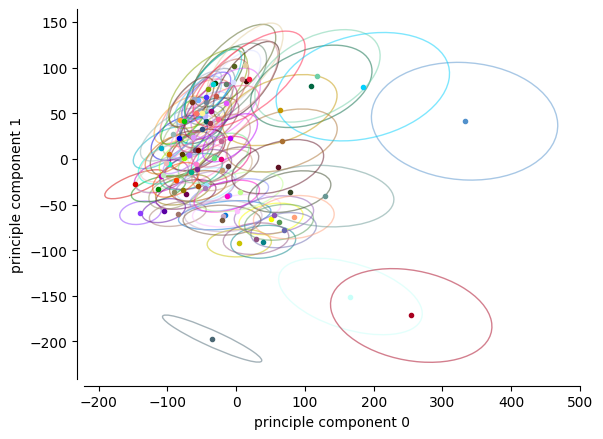

In [13]:
ax = plt.gca()

for v, (mean, cov) in enumerate(zip(syllable_means, syllable_covs)):
    c = cc.glasbey[v]
    ax.scatter(mean[0], mean[1], c=c, marker='.')
    confidence_ellipse(mean, cov, ax, n_std=1, edgecolor=c, alpha=0.5, zorder=0)

ax.set_xlabel("principle component 0")
ax.set_ylabel("principle component 1")
sns.despine(offset=5)

**Syllable feature distribution in the top 2 principle distributions.** Many syllable distributions exhibit strong overlap in the top 2 PCs. They likely differentiate in lower dimensions.
Each color represents a different syllable.

## Sort syllables

### Compute pairwise distance matrix
We compute the symmetric Kullback-Leibler diveregence between two Gaussian distributions, $P$ and $Q$,
$$
d(P,Q) = \frac{1}{2} \left(\textrm{KL}(P || Q) + \textrm{KL}(Q || P) \right).
$$

In [14]:
# ~2 minutes to compute

# Define distance function
symmetric_kl = lambda distr_a, distr_b: (
    0.5*(distr_a.kl_divergence(distr_b) + distr_b.kl_divergence(distr_a)) / prod(distr_a.event_shape)
)

syllable_distrs = [MVN(mean, cov, name=f'{v}') for mean, cov in zip(syllable_means, syllable_covs)]

# Cannot vmap tfd objects, so do old school product iteration
unsorted_dist_mat = []
for distr_a, distr_b in tqdm(itertools.product(syllable_distrs, syllable_distrs), total=n_syllables**2):
    unsorted_dist_mat.append(symmetric_kl(distr_a, distr_b))

unsorted_dist_mat = onp.asarray(unsorted_dist_mat).reshape(n_syllables, n_syllables)

  0%|          | 0/8100 [00:00<?, ?it/s]

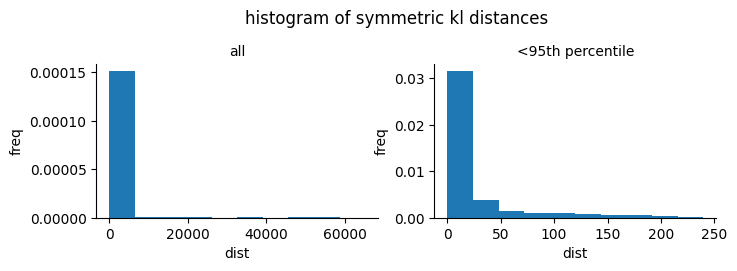

In [15]:
idxs = onp.tril_indices_from(unsorted_dist_mat, k=-1)
dist_flat = unsorted_dist_mat[*idxs]

fig, axs = plt.subplots(ncols=2, figsize=(8,2))
for ax, pct, title in zip (axs, [100, 95], ["all dists", "<90th percentile dists"]):
    threshold = onp.percentile(dist_flat, pct)
    mask = dist_flat.ravel() < threshold
    ax.hist(dist_flat.ravel()[mask], density=True)
    ax.set_xlabel("dist")
    ax.set_ylabel('freq')

    if pct == 100:
        ax.set_title("all", fontsize='medium')
    else:
        ax.set_title(f"<{pct}th percentile", fontsize='medium')

fig.suptitle("histogram of symmetric kl distances", y=1.15)
sns.despine()

**Histogram of pairwise distances.** These plots indicate that 95% of the distances lie in the range between 0 and 250 (right), but there are some very large outliers (left).

Text(0.5, 1.02, 'unsorted distance matrix')

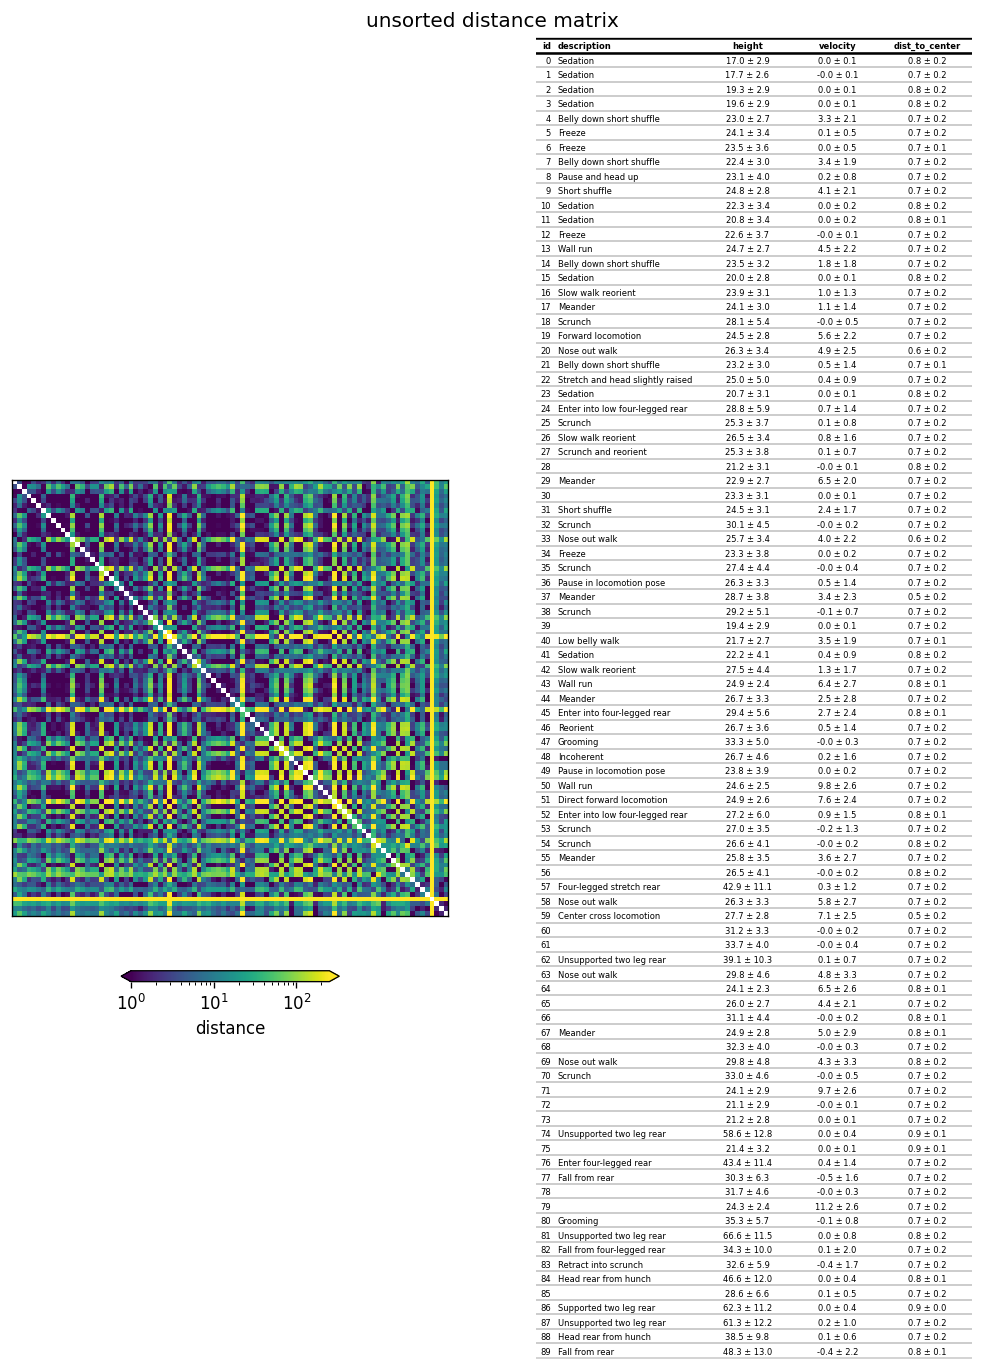

In [21]:
# Plot unsorted distance matrix
fig = plot_dist_and_descr(unsorted_dist_mat, aux_syllable_info.drop(columns='category'), perm=None, width_ratios=[4,4])

# hide tick labels, we will annotate most -> least frequent
ax_mat = fig.axes[0]
ax_mat.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

fig.suptitle(f"unsorted distance matrix", y=1.02)

# # Save figure
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
# fig.savefig('unsorted_syllables_result.pdf', transparent=True, format='pdf', bbox_inches='tight')
# fig.savefig('unsorted_syllables_result.svg', transparent=True, format='svg', bbox_inches='tight')

**Computed pairwise distance matrix.**
Original distance matrix, with rows and columns ordered from syllable 0 (most frequenct) to 89 (less frequent),
using a linear color mapping (left) and a logarithmic color mapping (right)
The "hatched" texture of the distance matrix suggests that there is indeed structure within the data.

As suggested by the histograms, there are some outlier pairwise distances. We will hold out some of the rows with outlier distance (syllable 86, and syllables 32, 47, 74 that are "similar" to 86) to ensure smooth fitting,
and we will incorporate them back in at the end of the analysis.

#### Holdout syllables with outlier distances 

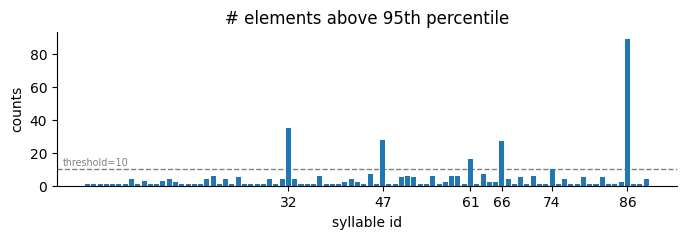

In [16]:
threshold = 10

pct = 95
ix = onp.nonzero(
    onp.where(unsorted_dist_mat>onp.percentile(unsorted_dist_mat, pct), True, False)
)[0]

ix, ix_unique = onp.unique(ix, return_counts=True)

fig, ax = plt.subplots(figsize=(8,2))
ax.bar(ix, ix_unique)
ax.set_xlabel('syllable id'); ax.set_ylabel('counts')
ax.set_xticks(ix[ix_unique>=threshold])
ax.axhline(threshold, color='0.5', ls='--', lw=1, zorder=0)
ax.set_title(f'# elements above {pct}th percentile')
ax.text(0.01, threshold+1, f"{threshold=}",
    transform=ax.get_yaxis_transform(),  # x: axis frac, y: data coords
    color='0.5', fontsize='x-small', ha='left', va='bottom',
)
sns.despine()

Text(0.5, 1.0, 'unsorted distance matrix, outliers heldout, 84 syllables')

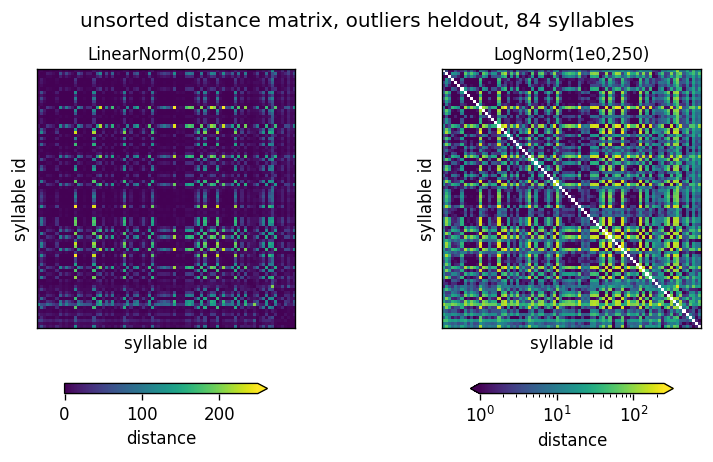

In [17]:
# Remove selected syllables for now
holdout_idxs = [32, 47, 61, 66, 74, 86]
inlier_dist_mat = onp.delete(onp.delete(unsorted_dist_mat, holdout_idxs, axis=0), holdout_idxs, axis=1)

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8,4), dpi=120)
# fig.subplots_adjust(bottom=0.2)  # make space for caxs

vmax = 250
for i_col, (norm, row_label) in enumerate(
    [(mpl.colors.Normalize(0,vmax), f"LinearNorm(0,{vmax})"), (mpl.colors.LogNorm(1e0,vmax), f"LogNorm(1e0,{vmax})")]
):
    ax = axs[i_col]

    im = ax.imshow(inlier_dist_mat, interpolation='none', norm=norm)

    # Don't show tick
    ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

    # Annotate
    ax.set_xlabel('syllable id')
    ax.set_ylabel('syllable id')
    ax.set_title(row_label, fontsize='medium')
    
    # Add colorbar to bottom
    plt.colorbar(im, ax=ax, location='bottom', shrink=0.6,
                 extend='max' if i_col==0 else 'both', label='distance')

fig.suptitle(f"unsorted distance matrix, outliers heldout, {len(inlier_dist_mat)} syllables", y=1.)

**Computed pairwise distance matrix, with selected rows removed.**
Same as previous, but with the indicated rows removed. The distance matrices display fewer outliers now.

In [18]:
# Remove selected syllables for aux info as well
outlier_aux_info = aux_syllable_info.loc[holdout_idxs]
inlier_aux_info = aux_syllable_info.drop(holdout_idxs).reset_index().drop(columns="index")
# inlier_aux_info.id = onp.arange(0, len(inlier_dist_mat))

print("Temporarily holding out the following syllables:")
outlier_aux_info

Temporarily holding out the following syllables:


id               description           category       height    velocity  \
32  32                   Scrunch           Grooming   30.1 ± 4.5  -0.0 ± 0.2   
47  47                  Grooming           Grooming   33.3 ± 5.0  -0.0 ± 0.3   
61  61                                                33.7 ± 4.0  -0.0 ± 0.4   
66  66                                                31.1 ± 4.4  -0.0 ± 0.2   
74  74  Unsupported two leg rear  Two-leg high rear  58.6 ± 12.8   0.0 ± 0.4   
86  86    Supported two leg rear  Two-leg high rear  62.3 ± 11.2   0.0 ± 0.4   

   dist_to_center  
32      0.7 ± 0.2  
47      0.7 ± 0.2  
61      0.7 ± 0.2  
66      0.8 ± 0.1  
74      0.9 ± 0.1  
86      0.9 ± 0.0

### Apply SPIN algorithm

Syllables discretize continuous pose data, so while they can be grouped into clusters (e.g. sedated vs. active), they also exhibit sub-clusters (e.g. locomotion vs. rear) and continuous variation (e.g. slow locomotion, fast locomotion).
Typical approaches to clustering (e.g. k-means, agglomerative clustering) explicitly aim to partition the data into distinct groups seperated by abrupt changes and/or do not consider both global and local structure.
When applied to data with continuous variation, these clusterings become inherently arbitrary.
Permutation of the resulting distance matrices using these clusterings obscures potential structure between the samples.

For a distance matrix $D\in\mathbb{R}^{n\times n}$ calculated from a dataset of $n$ samples,
the objective is to identify a permutation $P \in \mathbb{S}_n$ that orders the elements in a way that reveals underlying structure.
This ordering problem is described the general family of cost functions
$$
\mathcal{F}(P) = \textrm{tr}\left(W \, P D P^\mathsf{T}\right) = \sum_{i,j=1}^n W_{ij} D_{P(i)P(j)}
$$
for some weight matrix $W \in \mathbb{R}^{n\times n}$.

Tsafrir et al. (2005) remark that one desirable property of distance matrices with continuous variation is that elements near the main diagonal should be similar.
They refer to this property as the "neighborhood" property, and encode this in a doubly stochastically normalized Gaussian weight matrix with unnormalized entries
$$
    \left[\widetilde{W}(s)\right]_{ij} = \exp\left\{-\frac{(i-j)^2}{s}\right\}.
$$
for some neighborhood size $s\in\mathbb{R}_{++}$.
Intuitively, this matrix selects

the weight matrix as an exponentially concentrated region around the diagonal,

Solving $\mathcal{F}$ is NP-hard, but they provide two iterative heuristic algorithms for searching the minima with convergence guarantees.

In motivating an alternative algorithm for permuting distance matrices with continuous and compound structure,  comment that one property of a "well-ordered" distance matrix is that elements near the main diagonal have are similar.
They refer to this property as the "neighborhood" property, and encode this 


Tsafrir et al. (2005) address this problem by proposing a sorting algorithm based on solving for a linear ordering such that along the diagonal, elements have distances along the diagonal.

**TODO: (Neighborhood algorithm is similar but diff from traveling salesperson, but how exactly??)**
It's like a...soft traveling salesman problem? because of exponential weighting

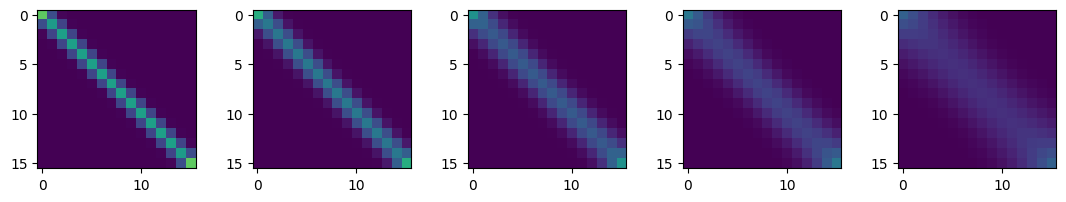

In [25]:
neighborhood_sizes = [1, 2, 4, 8, 16]

fig, axs = plt.subplots(ncols=len(neighborhood_sizes), figsize=(16, 0.9*(16/7.)))
fig.subplots_adjust(left=0.2, right=0.85)  # make space for caxs
for ax, s in zip(axs, neighborhood_sizes):
    mat = initial_weight_matrix(16, s / 16.)

    im = ax.imshow(mat, interpolation='none', clim=(0,1))


In [19]:
dist_mat = inlier_dist_mat
aux_info = inlier_aux_info

In [20]:
n_inits = 10
seed = 0

rng =  onp.random.default_rng(seed=seed)

all_perms = []
for i_init in range(n_inits):
    init_perm = rng.permutation(len(dist_mat))

    clusterer = NeighborhoodSPIN(max_iter=200).run(dist_mat[init_perm, :][:, init_perm])

    # Save the solution relative to the "raw" distance matrix
    next_perm = onp.nonzero(clusterer.permutation_)[1]
    all_perms.append(init_perm[next_perm])

Text(0.5, 1.0, 'sorted distance matrices from different initializations')

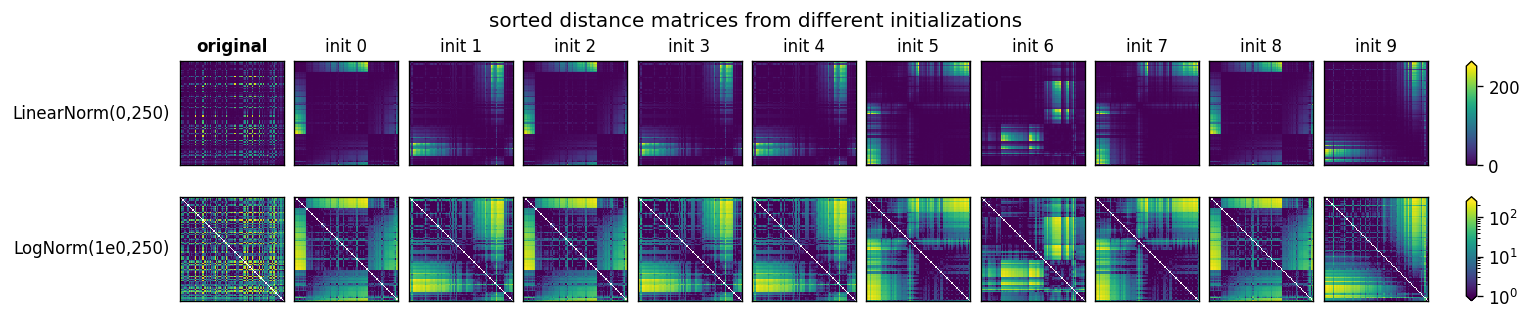

In [21]:
fig, axs = plt.subplots(
    nrows=2, ncols=n_inits + 1, gridspec_kw={'hspace': 0.1, 'wspace': 0.1},
    figsize=(16, 1.75*(16/n_inits)), dpi=120
)
fig.subplots_adjust(left=0.2, right=0.85)  # make space for caxs

vmax = 250
for i_row, (norm, row_label) in enumerate(
    [(mpl.colors.Normalize(0,vmax), f"LinearNorm(0,{vmax})"), (mpl.colors.LogNorm(1e0,vmax), f"LogNorm(1e0,{vmax})")]
):
    for i_col, perm in enumerate([onp.arange(len(dist_mat))] + all_perms):
        ax = axs[i_row, i_col]

        im = ax.imshow(dist_mat[perm, :][:, perm], interpolation='none', norm=norm)

        ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False,)

    # Label row
    axs[i_row,0].text(
        -0.1, 0.5, row_label, transform=axs[i_row,0].transAxes,
        ha="right", va="center", fontsize='medium'
    )

    # Add cax to RHS
    l, b, w, h = axs[i_row, -1].get_position().bounds
    cax = fig.add_axes((0.87, b, 0.1*w, h))
    plt.colorbar(im, cax=cax, extend='max' if i_row==0 else 'both')

# Label columns
axs[0,0].set_title(f'original', fontweight='semibold', fontsize='medium')
for i, ax in enumerate(axs[0,1:]):
    ax.set_title(f'init {i}', fontsize='medium')

fig.suptitle("sorted distance matrices from different initializations", y=1.)

**Sorted syllable feature distance matrix for different initializations of the SPIN algorithm.**
The original distance matrix, sorted from most to least frequently used syllables, is shown in the first column, for both a linear color normalization (top) and logarithmic color mapping (bottom).
The "hatched" texture of the distance matrix, which is particularly visible in the logarithmic color mapping, supports that there is structure within the data.
The subsequent columns show different permutations of the original matrix found by the SPIN algorithm, for different initializations.

We identity 3 consistent solutions from amongst the 10 initializations. We inspect the sorted auxiliary info (i.e. descriptions and scalar quantities) to choose the best ordering.

In [22]:
def find_cluster_edges(dist_mat, perm=None, neighborhood_size=10, **kwargs):
    """Compute local neighborhood dispersion; large changes indicate potential cluster.
    
    Parameters
        dist_mat: array, shape (size, size)
        perm: array, shape (size). optional.
        neighborhood_size: int, default=10.
            Neighborhood size (in units of elements) to calculate weights from.
            Larger values will be less sensitive to clusters.
            A normalized version of the `initial_sigma` parameter in SPIN algorithm.
        kwargs: dict.
            Keyword arguments to pass into `scipy.signal.peak`.
    
    Returns
        cost_vec: array, shape (size,)
        peaks: array, shape (n_peaks,)
        props: peak properties, same as `scipy.signal.peak`
    """

    size = len(dist_mat)

    if perm is None:
        perm = onp.arange(size)

        
    sorted_dist_mat = dist_mat[perm,:][:,perm]

    # The `sigma` parameter in initial_weight_matrix is dependent on the matrix size
    # Here, we define neighborhood size _independent_ of size, and in units of "# neighbors"
    weight_mat = initial_weight_matrix(size, neighborhood_size / size)

    # Diagonal of the "mismatch" matrix, whose trace is minimized in the sorting algorithm
    cost_vec = onp.diag(sorted_dist_mat @ weight_mat)

    # Peaks in neighborhood distances indicate potential clusters
    peaks, props = find_peaks(cost_vec, **kwargs)

    return cost_vec, peaks, props


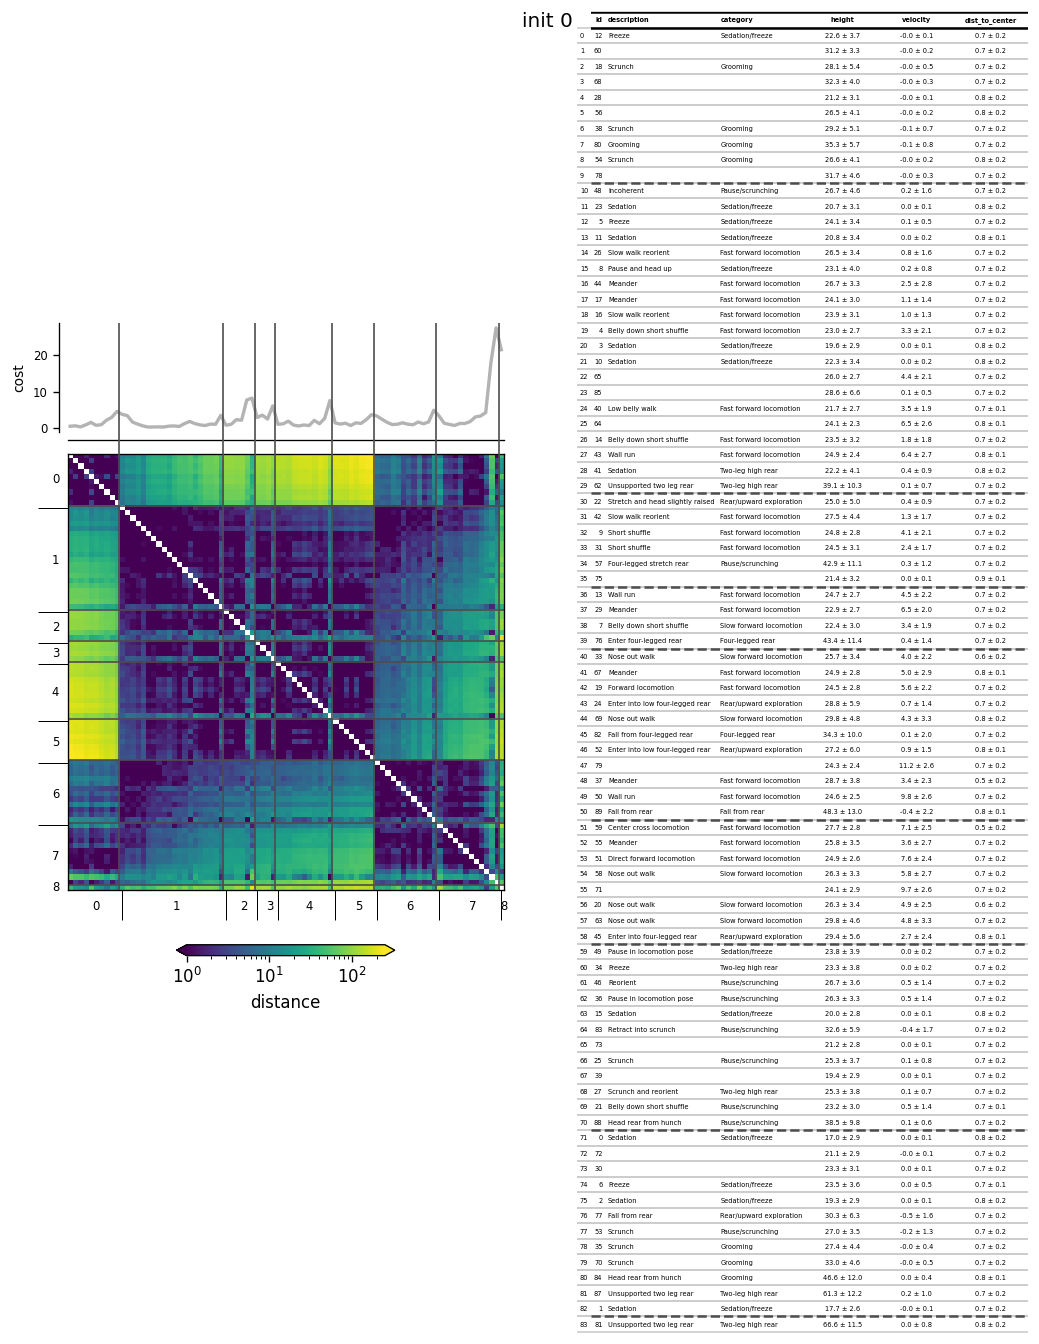

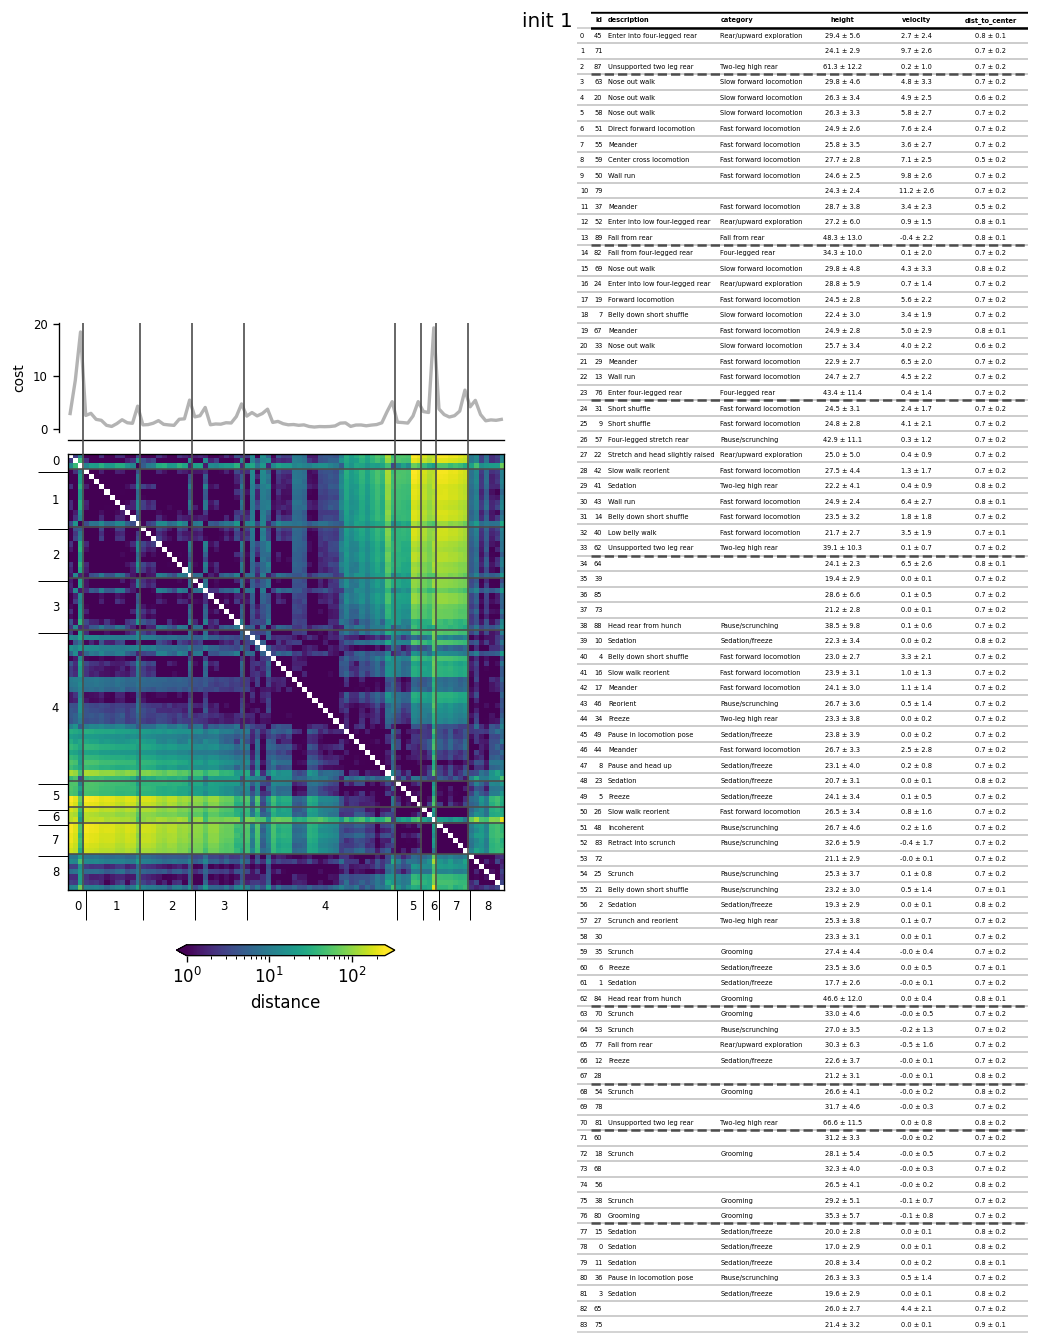

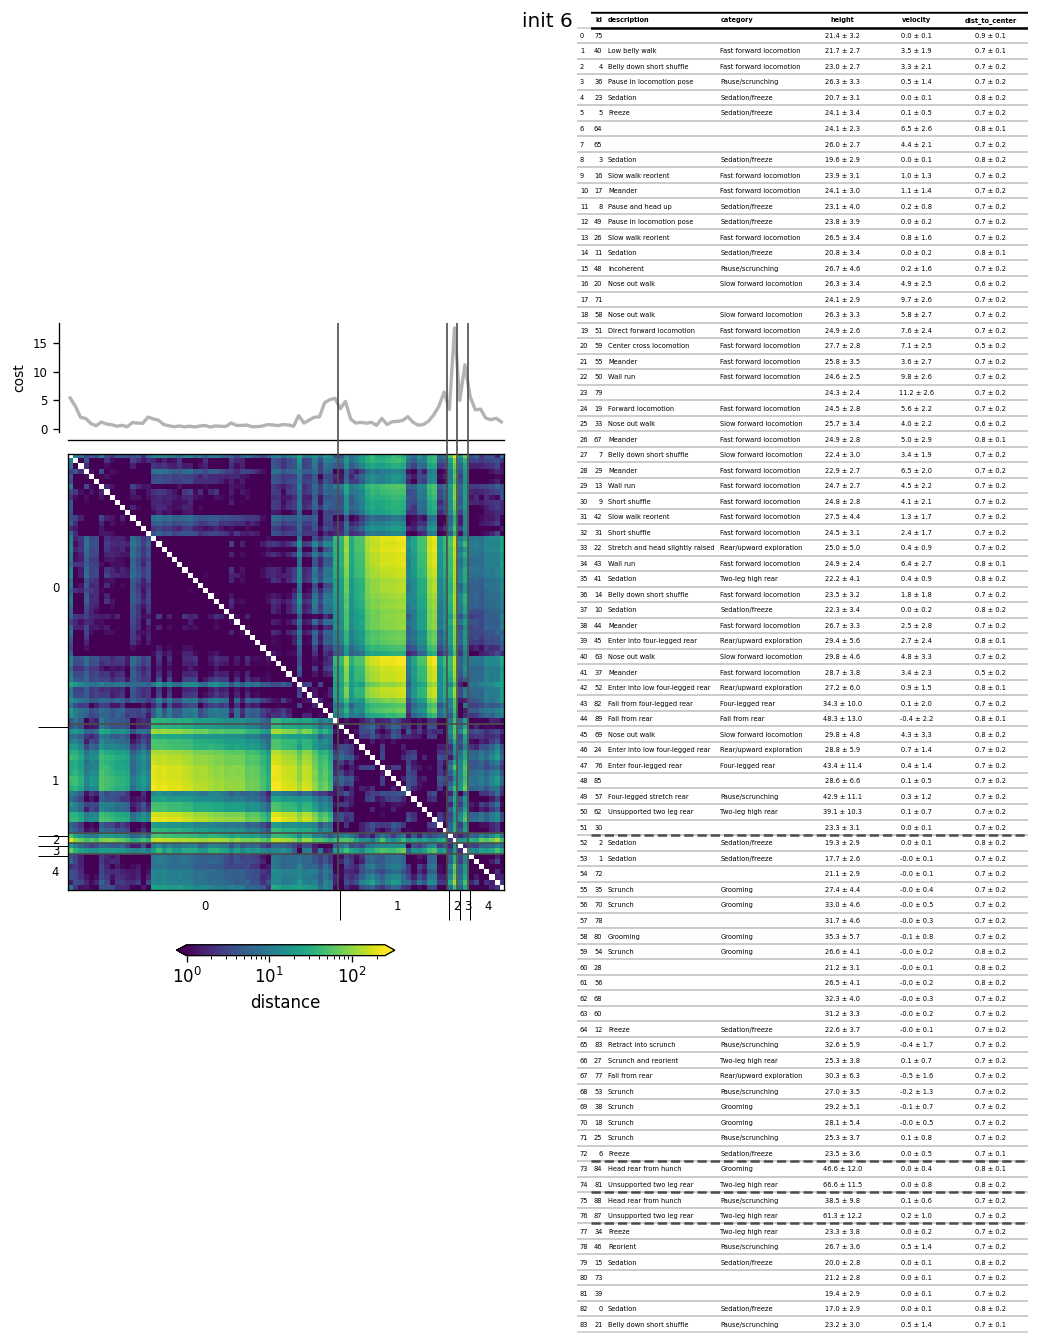

In [23]:
selected_inits = [0,1,6]

for i_init in selected_inits:
    selected_perm = all_perms[i_init]

    cost_vec, peaks, props = find_cluster_edges(dist_mat, selected_perm, neighborhood_size=10, prominence=2)

    cluster_edges = onp.concatenate([[0], peaks+2, [len(dist_mat)]], dtype=float)

    # ------------------------------------------------------------------------------------
    # Plot and hope nothing explodes
    # ------------------------------------------------------------------------------------
    fig = plot_dist_and_descr(
        dist_mat, aux_info, perm=selected_perm,
        cost_vec=cost_vec, cluster_edges=cluster_edges,
        width_ratios=[4,4],  # ratios between plots (left) and table (right)
        show_table_row_labels=True,  # useful for debugging
    )

    fig.suptitle(f"init {i_init}", y=1)

**Detailed look at syllable order for different initializations.**

Of these, the first initializations ordering (`i_init=0`) has an interpretable ordering and grouping.
Some additional fine tuning is needed, which we proceed to do manually.

In [24]:
# (n_iters, n_inlier_syllables)
selected_perm_iters = onp.asarray([all_perms[0].copy()])
selected_perm_iters.shape

(1, 84)

##### Fine tune selection, iter 1

- Move indices 29, 34, 39, 50, 70 to near index 80
- Move 35 and 71 to beginning of 2nd block
- Move 82 to beginning of 1st block

In [25]:
this_iter = 1
selected_perm = selected_perm_iters[this_iter-1]

selected_perm = onp.concatenate([
    selected_perm[[82,4,0,1,2,3,5,6,7,8,9,]],  # insert 82, shift 4
    selected_perm[[35,71]],                    # insert 35 and 71
    selected_perm[10:13],
    selected_perm[13:29], selected_perm[30:34], selected_perm[36:39], selected_perm[40:50], selected_perm[51:59],
    selected_perm[59:70], selected_perm[72:80],
    selected_perm[[29,34,39,50,70]],    # insert 29, 34, 39, 50, 70
    selected_perm[[81,80]], selected_perm[[83]],  # Swap 80, 81
])

# ---------------------------------------------------------

size = len(dist_mat)
missing_idxs = onp.setdiff1d(onp.arange(size), selected_perm)
assert len(missing_idxs)==0, f"Missing: {missing_idxs}"

if len(selected_perm_iters) == this_iter:
    selected_perm_iters = onp.concatenate([selected_perm_iters, [selected_perm]])
elif len(selected_perm_iters)-1 > this_iter:
    selected_perm_iters[this_iter] = selected_perm
else:
    print(f"{len(selected_perm_iters)=}, but {this_iter=}")

# ---------------------------------------------------------

size = len(dist_mat)
missing_idxs = onp.setdiff1d(onp.arange(size), selected_perm)
assert len(missing_idxs)==0, f"Missing: {missing_idxs}"

# ---------------------------------------------------------

# plt.figure(figsize=(16,16), dpi=120)
# im = plt.imshow(dist_mat[selected_perm, :][:, selected_perm], interpolation='none', norm=norm)

# plt.xticks(onp.arange(size), labels=onp.arange(size), rotation=90)
# plt.yticks(onp.arange(size), labels=onp.arange(size));


Text(0.5, 1.02, 'fine tune, iter 1')

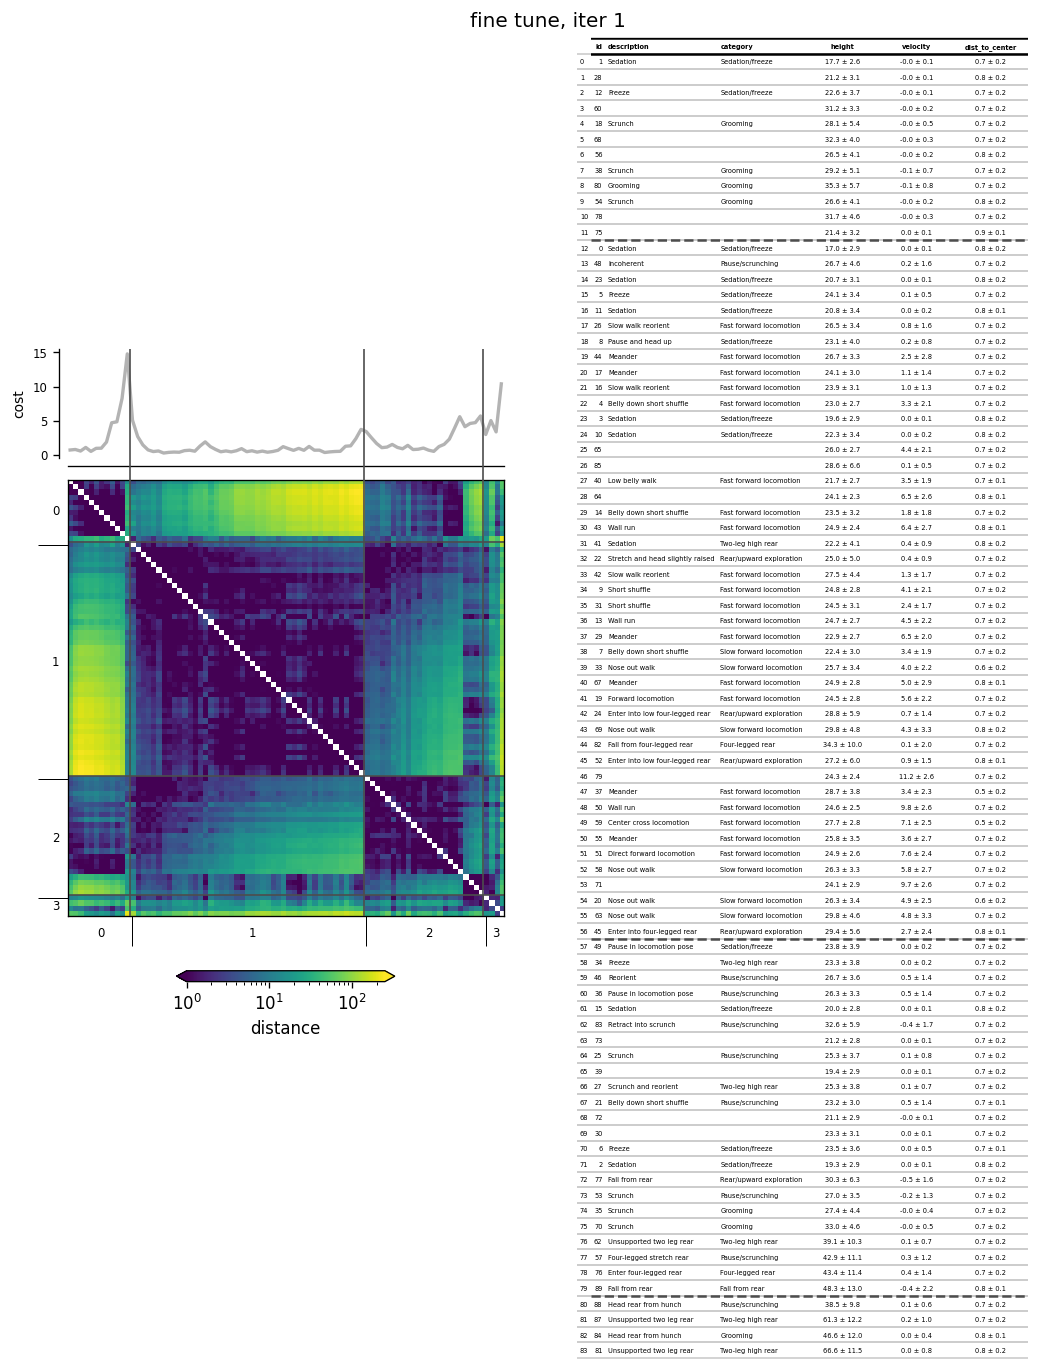

In [26]:
selected_perm = selected_perm_iters[this_iter]

cost_vec, peaks, props = find_cluster_edges(dist_mat, selected_perm, neighborhood_size=10, prominence=2)

# ------------------------------------------------------------------------------------
# Plot and hope nothing explodes
# ------------------------------------------------------------------------------------
cluster_edges = onp.concatenate([[0], peaks+2, [size]], dtype=float)

fig = plot_dist_and_descr(
    dist_mat, aux_info, perm=selected_perm,
    cost_vec=cost_vec, cluster_edges=cluster_edges,
    width_ratios=[4,4],  # ratios between plots (left) and table (right)
    show_table_row_labels=True,  # useful for debugging
)

fig.suptitle(f"fine tune, iter {this_iter}", y=1.02)

##### Fine tune selection, iter 2

- Move index `26` and `[42, 46)` to end of 2nd block, by `55`

In [27]:
this_iter = 2
selected_perm = selected_perm_iters[this_iter-1]

selected_perm = onp.concatenate([
    selected_perm[0:13],
    selected_perm[58:62],       # Insert 58, 61
    selected_perm[13:42], selected_perm[46:55],
    selected_perm[42:46],                                # Insert [42-45]
    selected_perm[55:58], selected_perm[62:]
])

# ---------------------------------------------------------
size = len(dist_mat)
missing_idxs = onp.setdiff1d(onp.arange(size), selected_perm)
assert len(missing_idxs)==0, f"Missing {len(missing_idxs)}"

# ---------------------------------------------------------

if len(selected_perm_iters) == this_iter:
    selected_perm_iters = onp.concatenate([selected_perm_iters, [selected_perm]], axis=0)
elif len(selected_perm_iters)-1 >= this_iter:
    selected_perm_iters[this_iter] = selected_perm
else:
    print(f"{len(selected_perm_iters)=}, but {this_iter=}")

# ---------------------------------------------------------
# plt.figure(figsize=(16,16), dpi=120)

# im = plt.imshow(dist_mat[selected_perm, :][:, selected_perm], interpolation='none', norm=norm)

# plt.xticks(onp.arange(size), labels=onp.arange(size), rotation=90)
# plt.yticks(onp.arange(size), labels=onp.arange(size));


Text(0.5, 1.02, 'fine tune, iter 2')

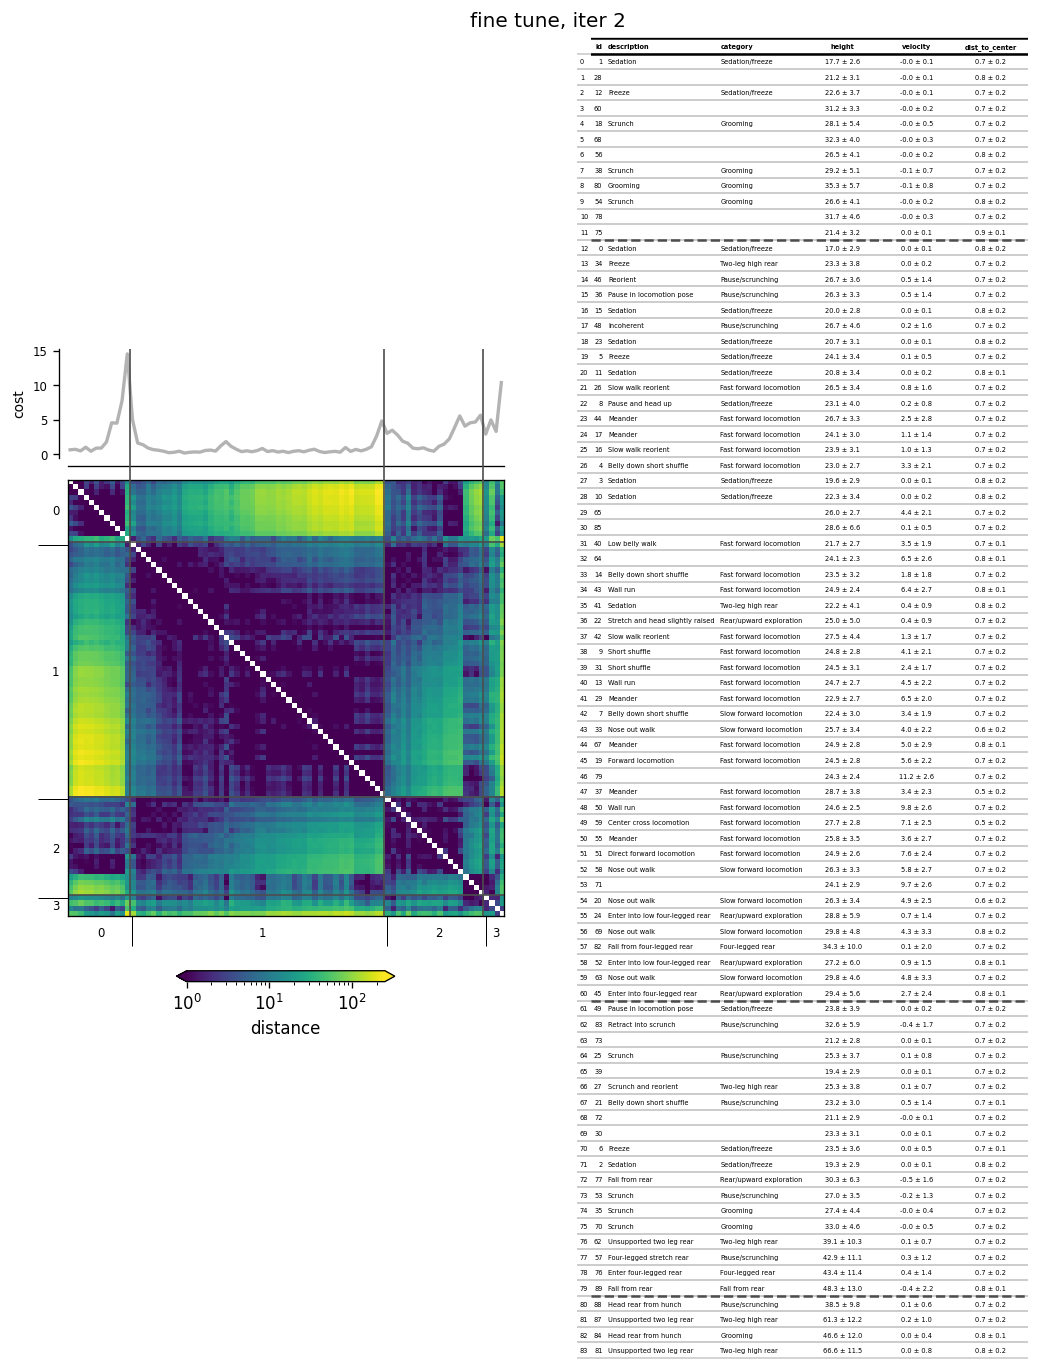

In [28]:
selected_perm = selected_perm_iters[this_iter]

cost_vec, peaks, props = find_cluster_edges(dist_mat, selected_perm, neighborhood_size=10, prominence=2)

# ------------------------------------------------------------------------------------
# Plot and hope nothing explodes
# ------------------------------------------------------------------------------------
cluster_edges = onp.concatenate([[0], peaks+2, [size]], dtype=float)

fig = plot_dist_and_descr(
    dist_mat, aux_info, perm=selected_perm,
    cost_vec=cost_vec, cluster_edges=cluster_edges,
    width_ratios=[4,4],  # ratios between plots (left) and table (right)
    show_table_row_labels=True,  # useful for debugging
)

fig.suptitle(f"fine tune, iter {this_iter}", y=1.02)

##### Fine tune selection, iter 3

We manually perform a "hierarchical" SPIN by extracting out the middle and bottom bottom blocks and independently running SPIN.

_Process not shown, but follows from above. Final permutations copy-pasted to prevent potential contamination of variable names._

In [29]:
this_iter = 3
selected_perm = selected_perm_iters[this_iter-1]

selected_perm = onp.concatenate([
    selected_perm[0:11],
    [70,0,45,33,15,35,5,23,26,46,3,62,11,10,29,22,39,4,61,17,16,42,43,8,80,77,41,24,50,44,65,60,36,32,53,57,20,56,63,48,14,40,9,31,13,7,19,49,67,74],  # results of running spin on subblock [11:61]
    [38,69,2,21,68,30,34,27,51,47,25,6,72,78,66,79,82,59,55,71,83,81,76],  # found of running spin on subblock [61:84]
])

# ---------------------------------------------------------
size = len(dist_mat)
missing_idxs = onp.setdiff1d(onp.arange(size), selected_perm)
assert len(missing_idxs)==0, f"Missing {len(missing_idxs)}"

# ---------------------------------------------------------

if len(selected_perm_iters) == this_iter:
    selected_perm_iters = onp.concatenate([selected_perm_iters, [selected_perm]], axis=0)
elif len(selected_perm_iters) > this_iter:
    selected_perm_iters[this_iter] = selected_perm
else:
    print(f"{len(selected_perm_iters)=}, but {this_iter=}")

# # ---------------------------------------------------------
# plt.figure(figsize=(16,16), dpi=120)
# im = plt.imshow(dist_mat[selected_perm, :][:, selected_perm], interpolation='none', norm=mpl.colors.LogNorm(1,250))

# plt.xticks(onp.arange(size), labels=onp.arange(size), rotation=90)
# plt.yticks(onp.arange(size), labels=onp.arange(size));


Text(0.5, 1.03, 'fine tune, iter 3')

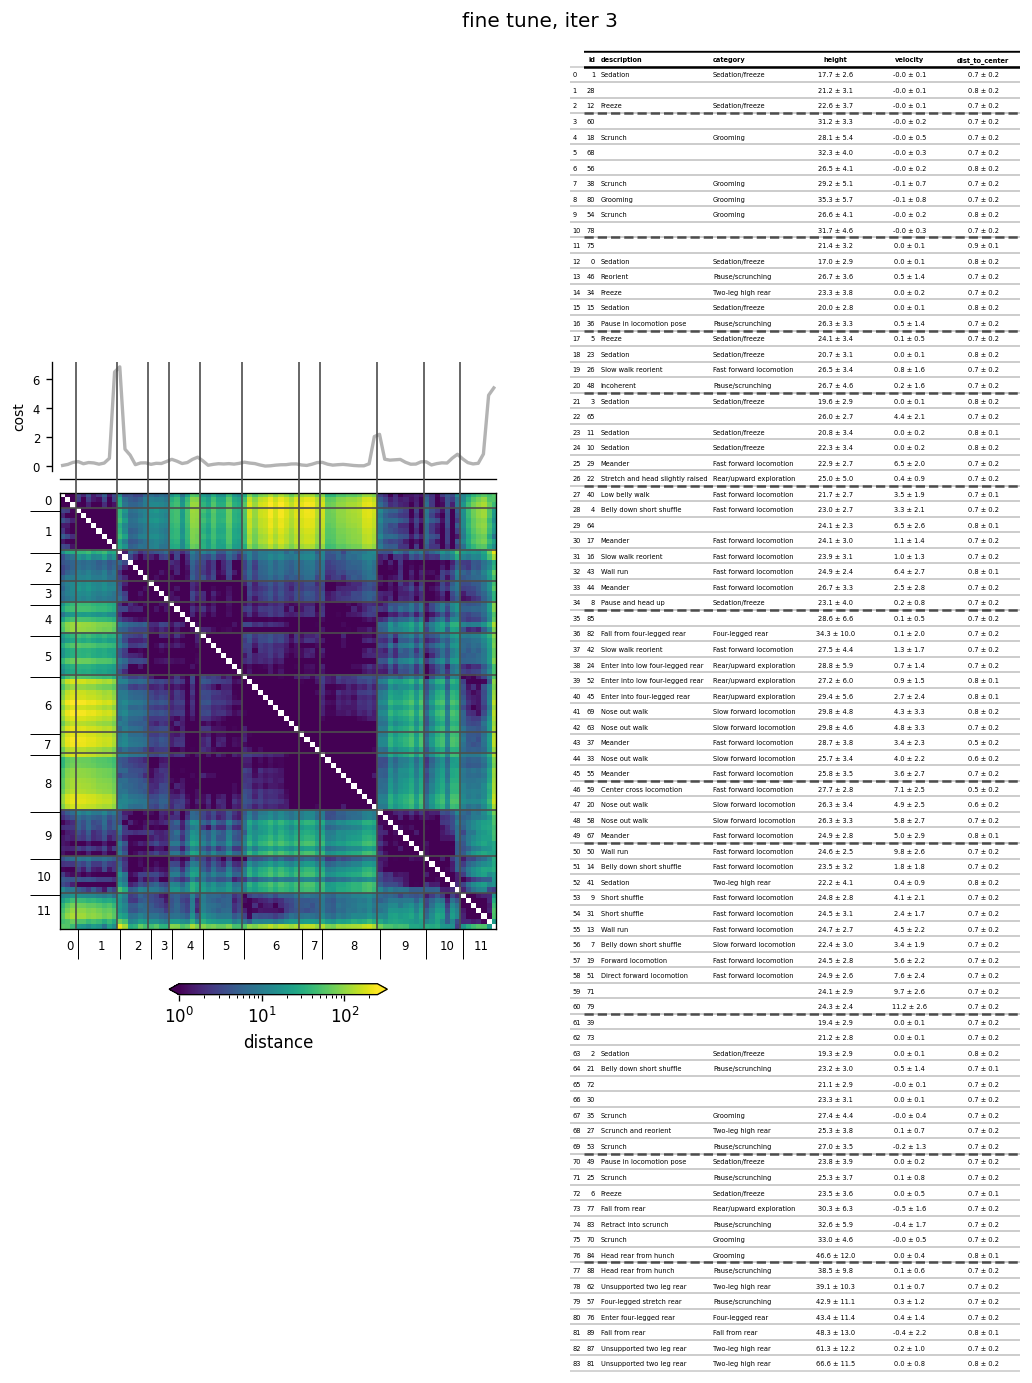

In [30]:
selected_perm = selected_perm_iters[this_iter]

cost_vec, peaks, props = find_cluster_edges(dist_mat, selected_perm, neighborhood_size=1, prominence=0.1)

# ------------------------------------------------------------------------------------
# Plot and hope nothing explodes
# ------------------------------------------------------------------------------------
peak_offset = [1,1,2,1,2,1,2,1,1,2,2]
cluster_edges = onp.concatenate([[0], peaks+peak_offset, [size]], dtype=float)

fig = plot_dist_and_descr(
    dist_mat, aux_info, perm=selected_perm,
    cost_vec=cost_vec, cluster_edges=cluster_edges,
    width_ratios=[4,4],  # ratios between plots (left) and table (right)
    show_table_row_labels=True,  # useful for debugging
)

fig.suptitle(f"fine tune, iter {this_iter}", y=1.03)

In [40]:
inlier_idxs = onp.setdiff1d(onp.arange(90), holdout_idxs)
inlier_perm = inlier_idxs[selected_perm_iters[-1]]
print(inlier_perm)

[ 1 28 12 60 18 68 56 38 80 54 78 75  0 46 34 15 36  5 23 26 48  3 65 11
 10 29 22 40  4 64 17 16 43 44  8 85 82 42 24 52 45 69 63 37 33 55 59 20
 58 67 50 14 41  9 31 13  7 19 51 71 79 39 73  2 21 72 30 35 27 53 49 25
  6 77 83 70 84 88 62 57 76 89 87 81]


The resulting permutation of the inlier syllables (with respect to the full 90 syllables) is
```
1, 28, 12, 60, 18, 68, 56, 38, 80, 54, 78, 75,  0, 46, 34, 15, 36, 5, 23, 26, 48,  3, 65, 11, 10, 29, 22, 40,  4, 64, 17, 16, 43, 44, 8, 85, 82, 42, 24, 52, 45, 69, 63, 37, 33, 55, 59, 20, 58, 67, 50,14, 41,  9, 31, 13,  7, 19, 51, 71, 79, 39, 73,  2, 21, 72, 30, 35, 27, 53, 49, 25,  6, 77, 83, 70, 84, 88, 62, 57, 76, 89, 87, 81
```

#### Reincorporate held-out syllables

In [46]:
dist_mat = unsorted_dist_mat
aux_info = aux_syllable_info

In [ ]:
# Let's add outliers to the end of the inliers
selected_perm = onp.concatenate([inlier_perm, outlier_aux_info.id.to_numpy()])

selected_perm = onp.concatenate([
    selected_perm[:83], selected_perm[84:88],
    selected_perm[[83,88,89]],  # move 83 to 88
])

selected_perm = onp.concatenate([
    selected_perm[:11],
    selected_perm[83:87][::-1],  # move scrunch and grooming earlier too
    selected_perm[11:20],
    selected_perm[61:77],        # move pause/scrunch block earlier
    selected_perm[20:61], selected_perm[77:83], selected_perm[87:]
])

# ---------------------------------------------------------
size = len(dist_mat)
missing_idxs = onp.setdiff1d(onp.arange(size), selected_perm)
assert len(missing_idxs)==0, f"Missing {len(missing_idxs)}"

# ---------------------------------------------------------
# plt.figure(figsize=(16,16), dpi=120)
# im = plt.imshow(dist_mat[selected_perm,:][:,selected_perm], interpolation='none', norm=mpl.colors.LogNorm(1,250))

# plt.xticks(onp.arange(size), labels=onp.arange(size), rotation=90)
# plt.yticks(onp.arange(size), labels=onp.arange(size));

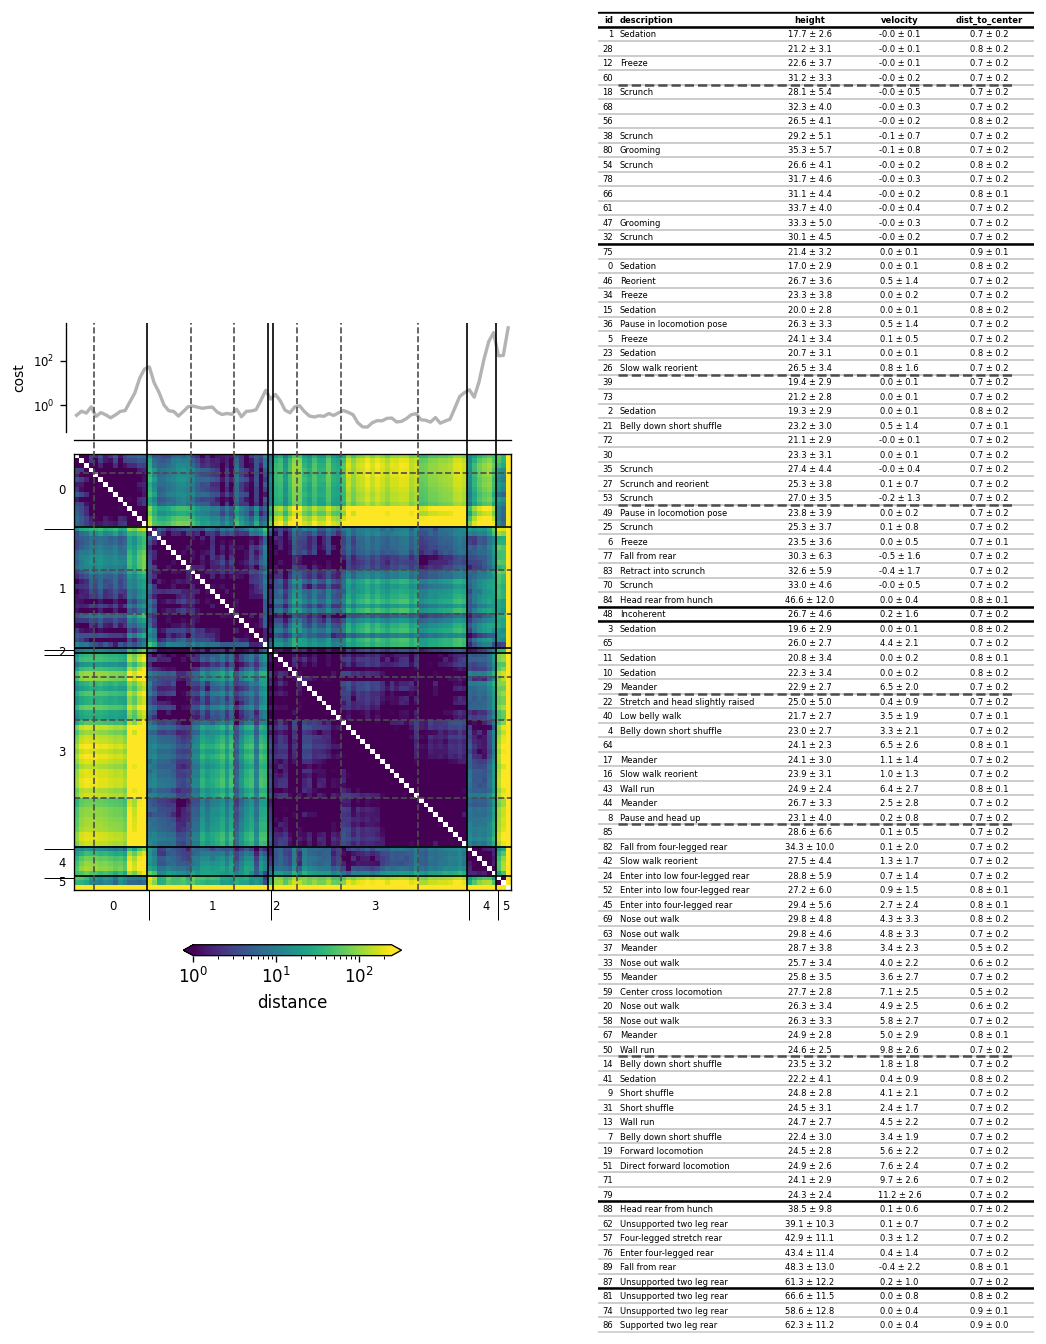

In [106]:
cost_vec, peaks, props = find_cluster_edges(dist_mat, selected_perm, neighborhood_size=5, prominence=0.2)

# Actual peak location +/- 1. This is for all peaks
# peak_offset = onp.ones(len(peaks))
peak_offset = onp.asarray([
    1,1,0,0,2,
    1,0,0,1,1,2
])

# Get "major" clusters
mask = props['prominences'] > 1
major_peaks = peaks[mask]
minor_peaks = peaks[~mask]

# ------------------------------------------------------------------------------------
# Plot and hope nothing explodes
# ------------------------------------------------------------------------------------

cluster_edges = onp.concatenate([[0], major_peaks+peak_offset[mask], [len(dist_mat)]], dtype=float)

fig = plot_dist_and_descr(
    dist_mat, aux_info.drop(columns='category'), perm=selected_perm,
    cost_vec=cost_vec, cluster_edges=cluster_edges,
    width_ratios=[4,4],  # ratios between plots (left) and table (right)
    # show_table_row_labels=True,  # useful for debugging
)

# Adjust cost vec scale
ax_cost = fig.axes[-3]
ax_cost.set_yscale('log')

# Draw minor clusters
edges = minor_peaks + peak_offset[~mask]

ax_mat, ax_left, ax_right = fig.axes[0], fig.axes[-2], fig.axes[-1]
ax_left.vlines(edges-0.5, 0, 1, color='0.3', lw=1, ls='--')
ax_right.hlines(edges-0.5, -0.5, 1.5, color='0.3', ls='--')

ax_mat.hlines(edges-0.5, *ax_mat.get_xlim(), color='0.3', lw=1, ls='--')

# fig.suptitle(f"adding heldout ids, iter 4", y=1.02)

We clean this up further by merging clusters 2 (minor cluster 6) and cluster 3, and clusters 4 (minor cluster 11) and 5.

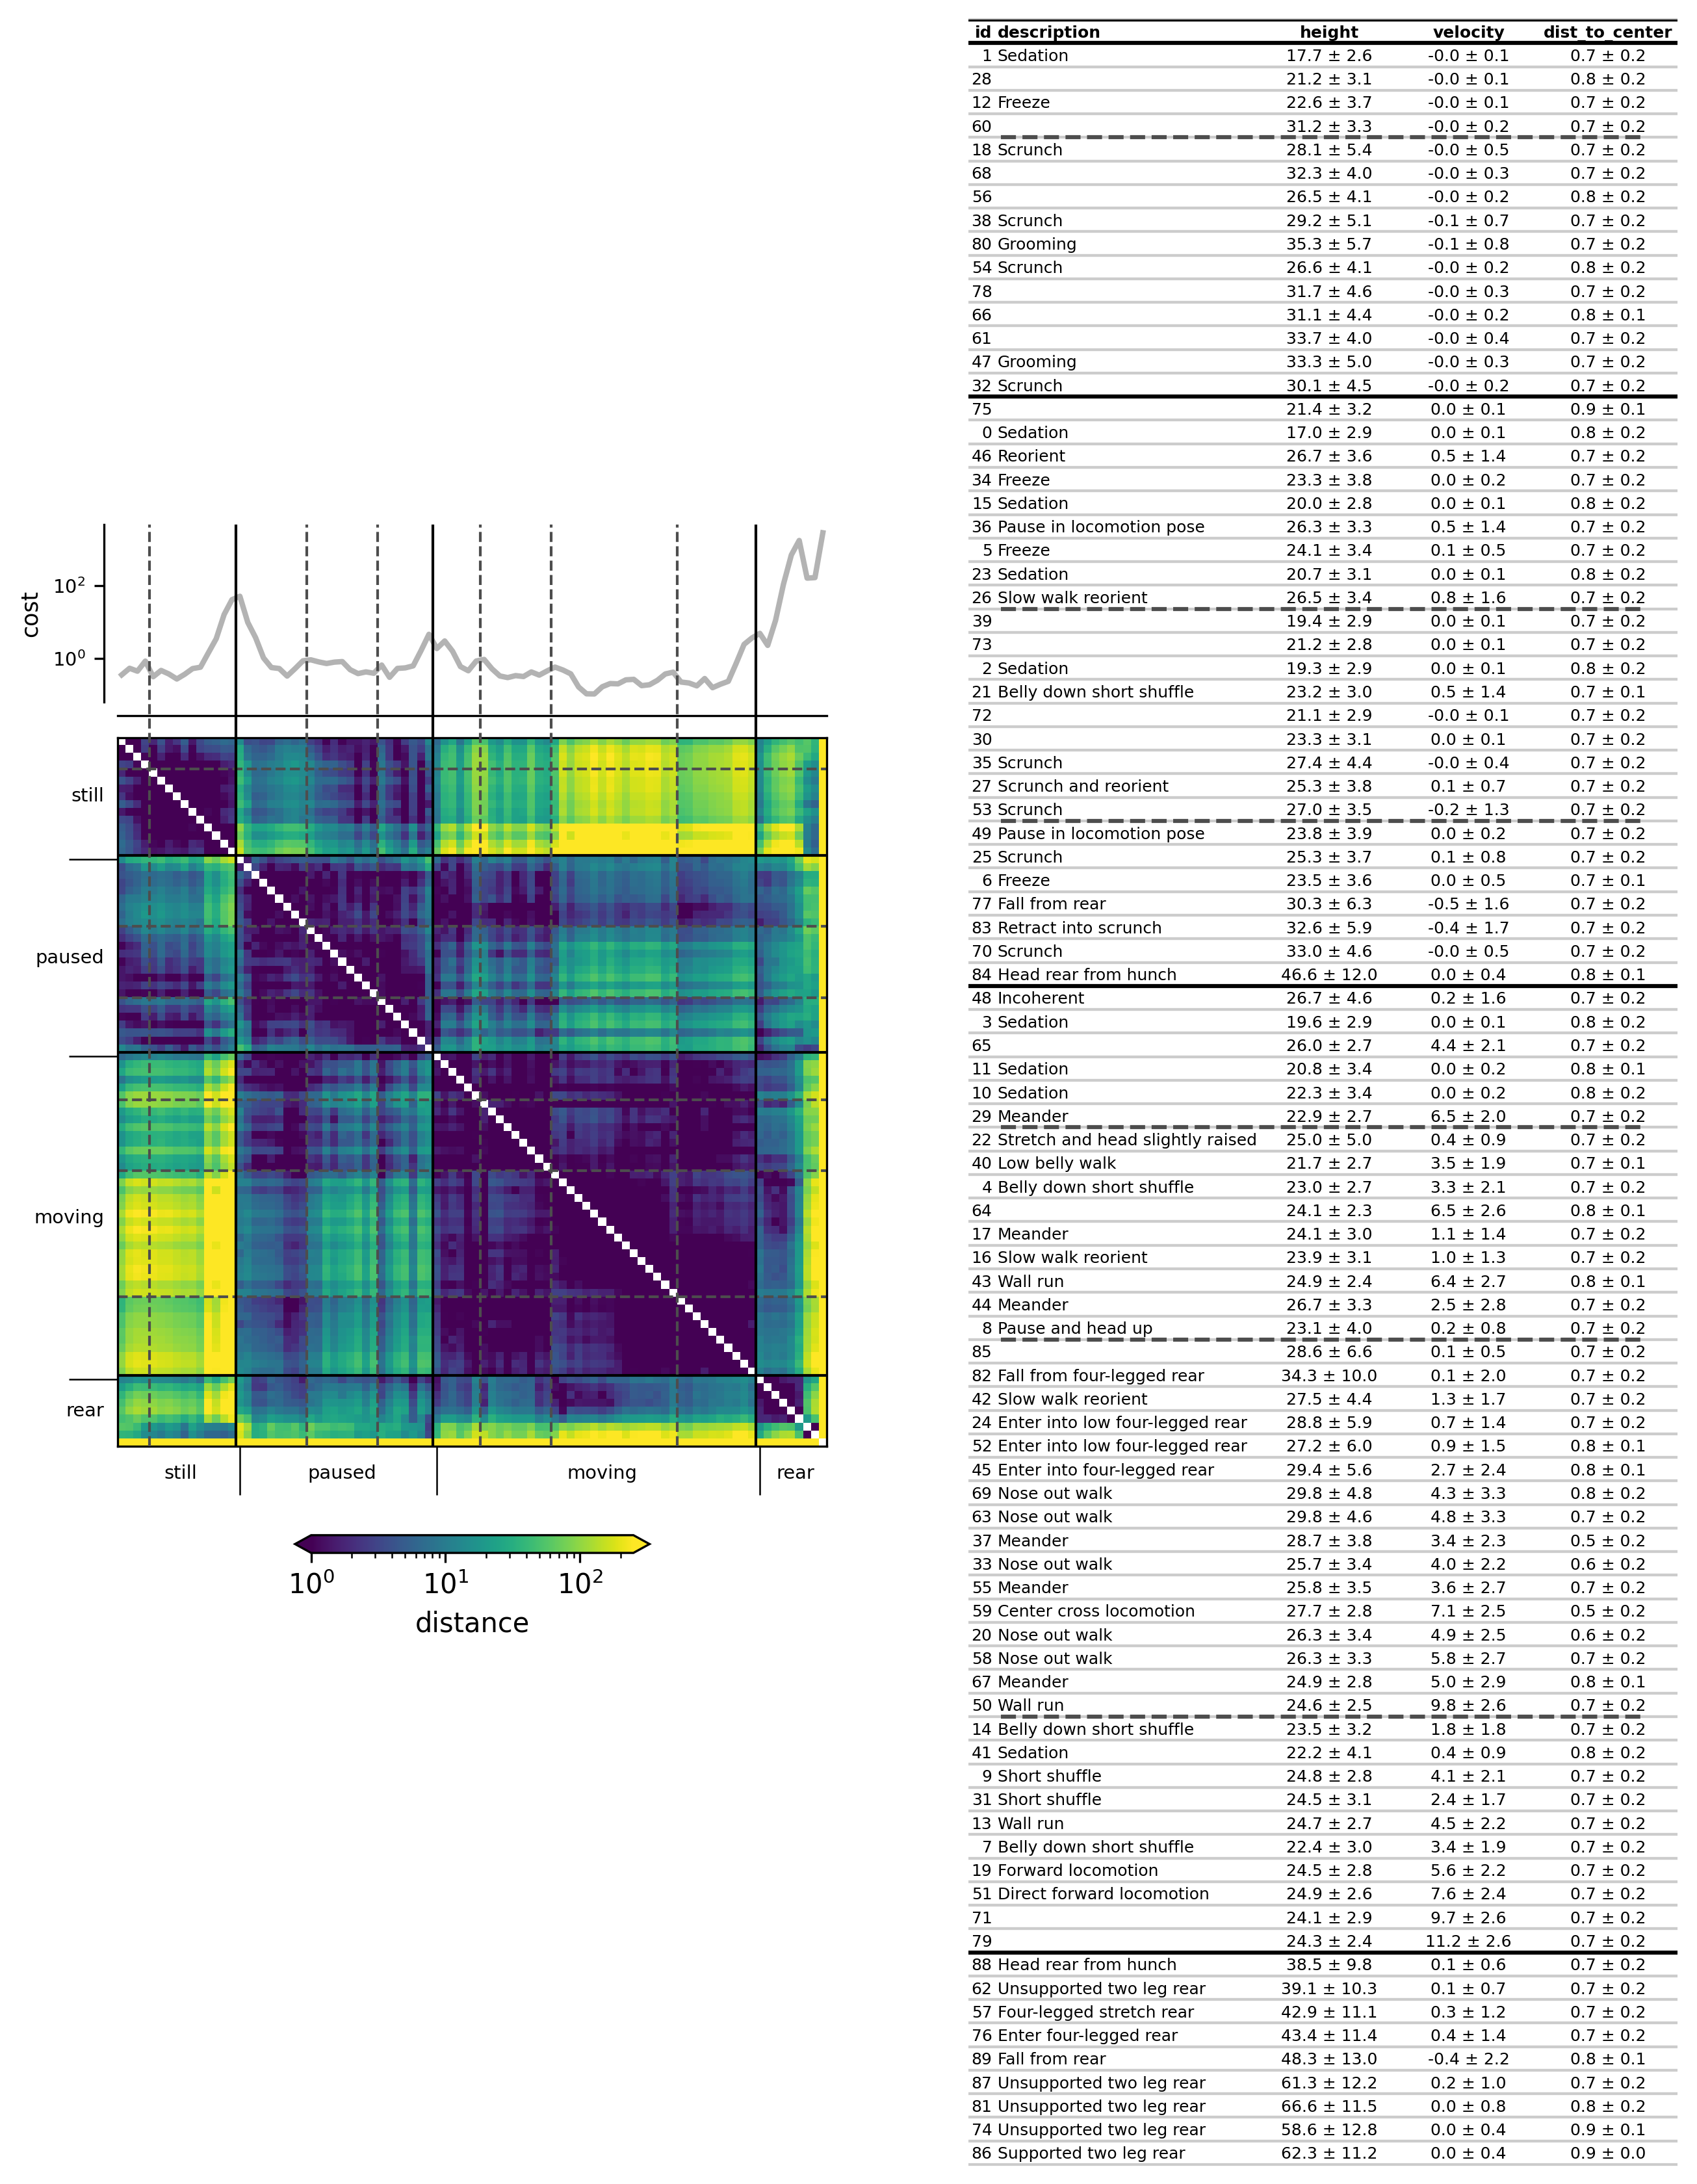

In [109]:
clean_mask = onp.ones(len(peaks), dtype=bool)
clean_mask[5] = False
clean_mask[10] = False
clean_peaks = peaks[clean_mask]
clean_offset = onp.asarray(peak_offset)[clean_mask]

mask = (props['prominences'] > 1)[clean_mask]
clean_major_peaks = clean_peaks[mask]
clean_minor_peaks = clean_peaks[~mask]

cluster_labels = ['still', 'paused', 'moving', 'rear',]
# -----------------------------------------------------------------------------------

cluster_edges = onp.concatenate([[0], clean_major_peaks+clean_offset[mask], [size]], dtype=float)

fig = plot_dist_and_descr(
    dist_mat, aux_info.drop(columns='category'), perm=selected_perm,
    cluster_labels=cluster_labels,
    cost_vec=cost_vec, cluster_edges=cluster_edges,
    width_ratios=[4,4],
    dpi=300,
)

# Adjust cost vec scale
ax_cost = fig.axes[-3]
ax_cost.set_yscale('log')

# Draw minor clusters
ax_mat = fig.axes[0]
ax_left, ax_right = fig.axes[-2:]
edges = clean_minor_peaks + clean_offset[~mask]

ax_left.vlines(edges-0.5, 0, 1, color='0.3', lw=1, ls='--')
ax_mat.hlines(edges-0.5, *ax_mat.get_xlim(), color='0.3', lw=1, ls='--')

ax_right.hlines(edges-0.5, -0.5, 1.5, color='0.3', ls='--')

# fig.suptitle(f"adding heldout ids, iter 4", y=1.02)

### Save figure

In [114]:
# # Save figure
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
# fig.savefig('sorted_syllables_result.pdf', transparent=True, format='pdf', bbox_inches='tight')
# fig.savefig('sorted_syllables_result.svg', transparent=True, format='svg', bbox_inches='tight')

In [112]:
# # Save results

# cluster_labels = ['still', 'paused', 'moving', 'rear']
# cluster_edges = onp.concatenate([[0], clean_major_peaks+clean_offset[mask], [90]])

# # flesh out cluster names
# cluster_names = []
# for lbl, counts in zip(cluster_labels, cluster_edges[1:]-cluster_edges[:-1]):
#     cluster_names.extend([lbl]*counts)

# arr = onp.stack([
#     selected_perm,
#     aux_info.loc[selected_perm].description.to_numpy(),
#     cluster_names
# ], axis=-1)

# arr = onp.concatenate([[['id','description','category']], arr], axis=0)

# arr = onp.asarray(arr, dtype=str)
# onp.savetxt(DATA_DIR/"syllable_id_label_cluster.csv", arr, fmt="%s", delimiter=",")

And...we aret done! And hope to never touch this again!

## Appendix: Hierarchical clustering in original paper

### Analyzed syllables are not all provided in original cladogram.
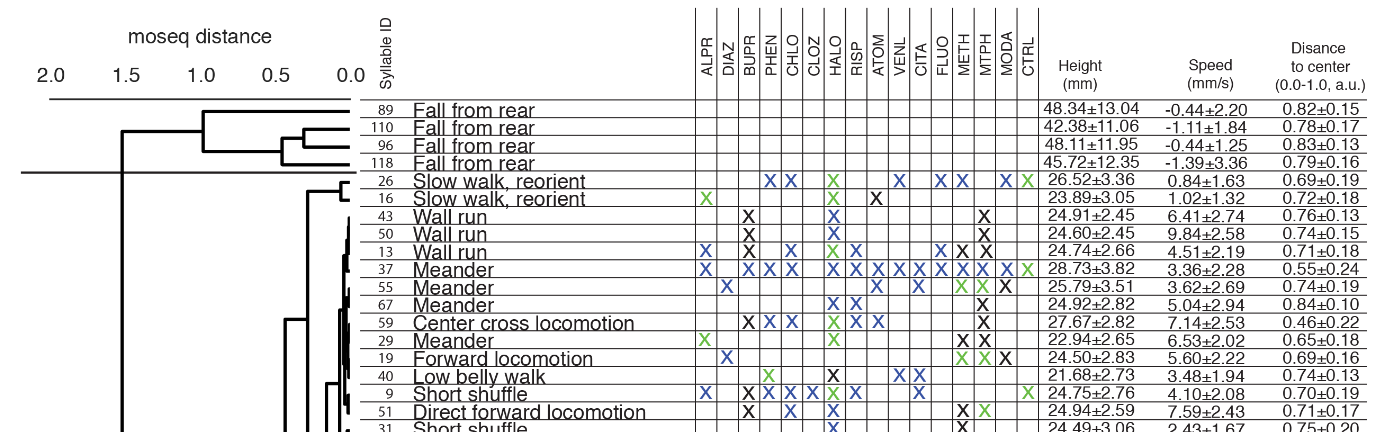

**Partial snapshot of Supplementary Figure 1. from Wiltschko et al. 2020**
showing _(from left to right)_ the agglomerative clustering dendrogram, syllable ID, plain description of behavior (identified via inspection), indicator of statistical significance of syllable to classifying each drug, and scalar quantifications of height, speed, and distance to arena for given syllable.
The hierarchical clustering was performed over a set of 90 syllables, $\mathcal{V}_\textrm{clustered}$, but this set does _not_ correspond to the analyzed syllable set, i.e. $\mathcal{V}_\textrm{clustered} \neq \mathcal{V}^\star$.
This is evident from a subset of the syllable IDs being $\geq 90$ in the above figure. Conversely, not all of the 90 most frequently used syllables have an ordering.

The inconsistency between analyzed syllables and clustered syllables does not impact the findings of the original paper because the clustered ordering was not used in any significant way.
The cladogram was used in Wiltschko et al.'s Extended Data Fig. 3 to aid in the interpretation of the syllables, and used in Supplementary Figs. 1 and 2 to qualitatively identify subsets of syllables that are predictive of drugs.

DTD builds on this "drug behavioral phenotype" interpretation and analysis because it identifies lower-dimensional factorizations that are characteristic of the treatments.
We use a comprehensive syllable ordering based on their feature similarity to aid in the interpretation and analysis of fitted dynamic topics.

Methods section
MoSeq-based behavioral distance measurements. To measure similarity between syllables, we performed MoSeq-based behavioral distance measurements as previously described11. Briefly, we assessed the similarity between pose trajectories of different syllables. We simulated pose trajectories for each syllable over 10 time steps (corresponding to 300 ms) using the autoregressive coefficients described by the AR-HMM model fit. Then, we computed the pairwise correlation distance (1 − Pe ars on’s r) between the top 90 most used syllables to generate a distance matrix, where low distances (near 0) represent similar syllables and high distances (near 2) represent dissimilar syllables. The cladogram was generated from the distance matrix using the Voor Hees hierarchical clustering algorithm (scipy.cluster.hierarchy.linkage).

## Appendix: Robust vs. empirical estimate of syllable pose feature parameters

Above, we used a robust estimate of syllable pose feature means and covariance via the Minimum Covariance Determinant (MCD) estimator.
Here, we visualize the difference between the robust and empirical estimates of the distribution.

In [29]:
emp_syllable_means, emp_syllable_covs = get_syllable_pose_feature_params(robust=False)

empirical:   0%|          | 0/90 [00:00<?, ?it/s]

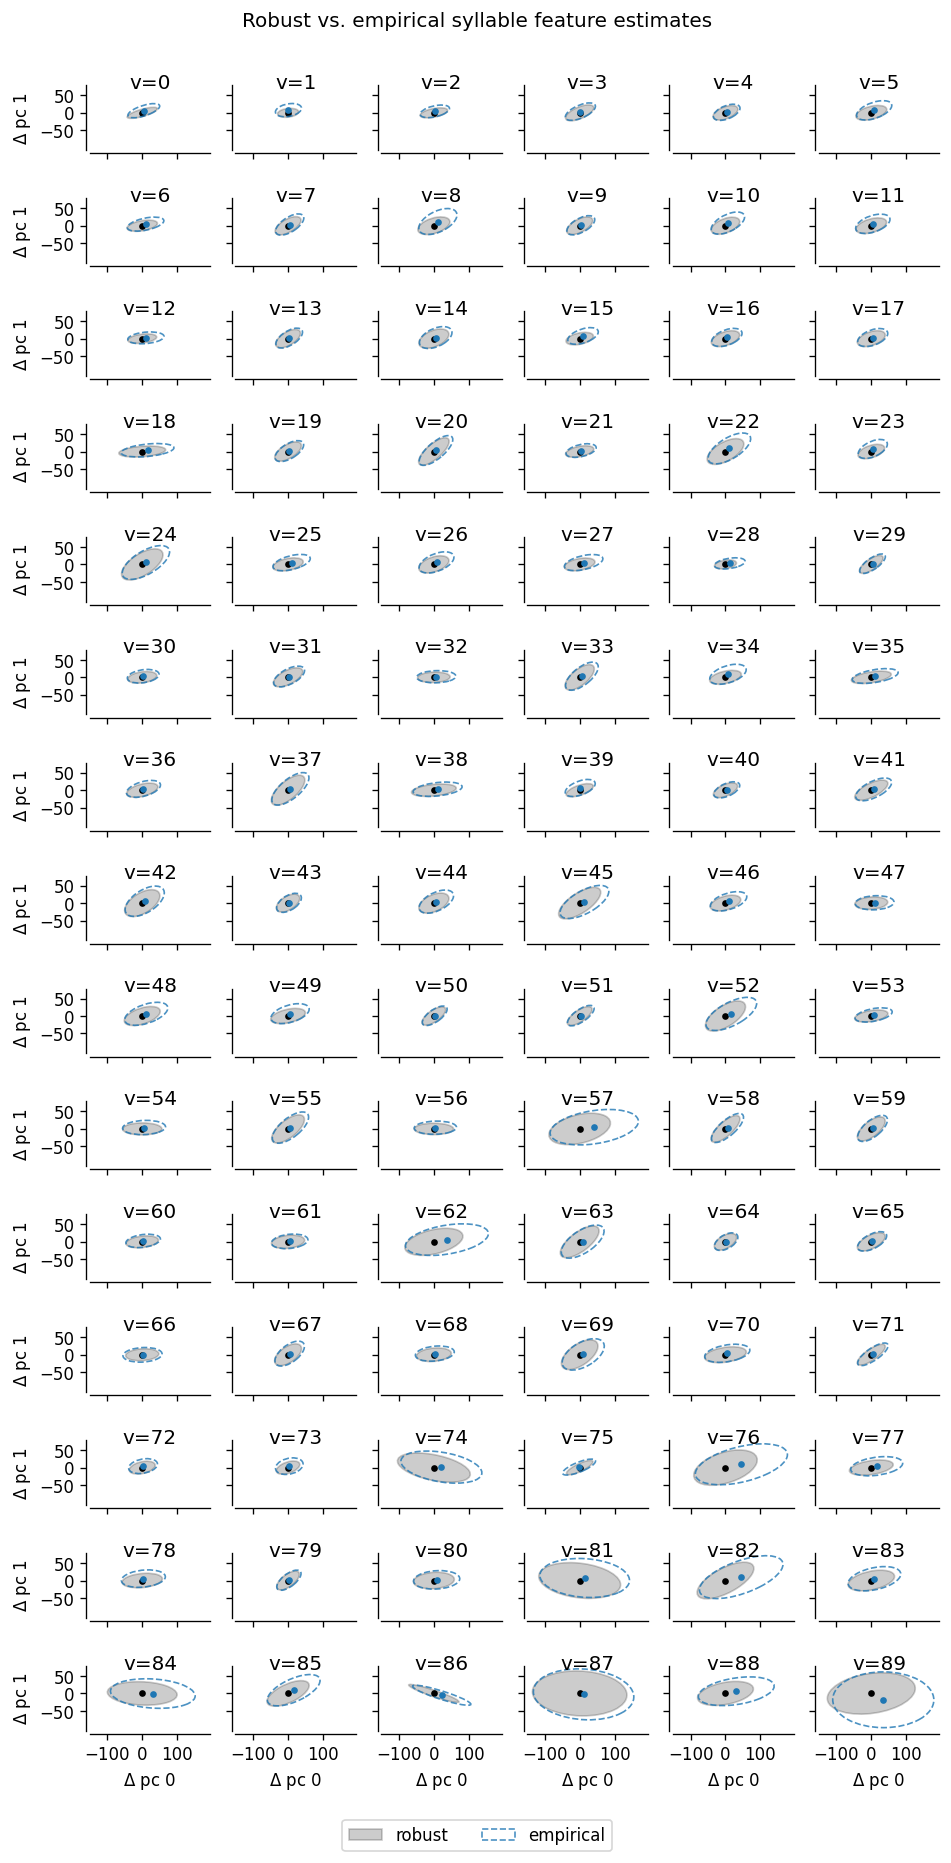

In [61]:
# We will plot the difference relative to the robust mean to simplify code
emp_dmean = emp_syllable_means - syllable_means

nrows, ncols = 15, 6
fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, sharex=True, sharey=True,
    subplot_kw={'aspect': 'equal'},
    figsize=(8, 15), dpi=120
)

robust_kwargs = dict(fc='k', ec='k', alpha=0.2,  lw=1,)
empirical_kwargs = dict(fc='none', ec='C0', ls='--', alpha=0.8)

for v in range(90):
    i_row = v // ncols
    i_col = v % ncols

    ax = axs[i_row, i_col]
    
    # Robust estimate
    ax.scatter(0, 0, marker='.', color=robust_kwargs['ec'])
    confidence_ellipse([0,0], syllable_covs[v], ax, n_std=1, **robust_kwargs)

    # Empirical estimate
    ax.scatter(emp_dmean[v,0], emp_dmean[v,1], marker='.', color=empirical_kwargs['ec'])
    confidence_ellipse(emp_dmean[v], emp_syllable_covs[v], ax, n_std=1, **empirical_kwargs)

    ax.set_title(f'{v=}', y=0.8)
    ax.set_yticks([-50,0,50])

# Label axes around the edges
for ax in axs[:,0]:
    ax.set_ylabel(r"$\Delta$ pc 1")
for ax in axs[-1,:]:
    ax.set_xlabel(r"$\Delta$ pc 0")

# Add legend
handles = [
    mpl.patches.Patch(**robust_kwargs, label='robust'),
    mpl.patches.Patch(**empirical_kwargs, label='empirical')
]
fig.legend(handles=handles, bbox_to_anchor=(0.5, 0), loc='upper center', ncols=len(handles))

fig.suptitle("Robust vs. empirical syllable feature estimates", y=1.0)
plt.tight_layout()
sns.despine(offset=2)

**Robust vs. empirical estimates of syllable pose feature distributions.**
Distributions are represented by their mean (marker) and one standard deviation of the covariance (ellipse), for robust (black) and empirical (blue) estimators, in their first two dimensions.
Empirical estimators are senstive to outliers, and the robust estimator recoveres the empirical estimates if there are no outliers in the data.
So, mismatch between the distributions indicate that there are outliers observations for that syllables. We note that a number of syllables have such mismatch.